In [1]:
import numpy as np
from transformers import AutoTokenizer, OPTModel
import torch
from test_utils import *

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")
model = OPTModel.from_pretrained("facebook/opt-350m")
atten_block = model.decoder.layers[0].self_attn

/Users/justin/anaconda3/envs/py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

# Load the Penn Treebank dataset with trust_remote_code set to True
dataset = load_dataset('ptb_text_only', 'penn_treebank', trust_remote_code=True)


In [3]:
from transformers import AutoTokenizer

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)


In [21]:
import torch
from transformers import OPTForCausalLM

# Initialize the model
model = OPTForCausalLM.from_pretrained("facebook/opt-350m")
model.eval()

# Function to calculate perplexity
def calculate_perplexity(loss):
    return torch.exp(loss)

# Calculate the loss and perplexity for the dataset
losses = []
for i, batch in enumerate(tokenized_dataset['train']):
    inputs = tokenizer(batch['sentence'], return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = inputs.input_ids[..., 1:].contiguous()
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses.append(loss.item())

# Calculate the average loss and perplexity
average_loss = sum(losses) / len(losses)
perplexity = calculate_perplexity(torch.tensor(average_loss))

print(f'Average Loss: {average_loss}')
print(f'Perplexity: {perplexity}')


Average Loss: 5.490324319777657
Perplexity: 242.33583068847656


In [4]:
model.decoder.layers[0]

OPTDecoderLayer(
  (self_attn): OPTAttention(
    (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
    (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
    (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
    (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (activation_fn): ReLU()
  (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=1024, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [5]:
# get total_number of macs (excluding activation)
import thop
bsz = 1
seq_len = 1
dummy_input = torch.randn(bsz, seq_len, model.decoder.layers[0].embed_dim)
decoder_macs, params = thop.profile(model.decoder.layers[0], inputs=(dummy_input,))

# get number of macs for each linear layer
k_proj_wrapper = SVDWrapper(atten_block.k_proj)
q_proj_wrapper = SVDWrapper(atten_block.q_proj)
v_proj_wrapper = SVDWrapper(atten_block.v_proj)
out_proj_wrapper = SVDWrapper(atten_block.out_proj)
fc_1_wrapper = SVDWrapper(model.decoder.layers[0].fc1)
fc_2_wrapper = SVDWrapper(model.decoder.layers[0].fc2)

# print
print("Total MACs: ", decoder_macs)
print("k_proj MACs: ", k_proj_wrapper.get_orignial_macs(seq_len), k_proj_wrapper.get_orignial_macs(seq_len)/decoder_macs)
print("q_proj MACs: ", q_proj_wrapper.get_orignial_macs(seq_len), q_proj_wrapper.get_orignial_macs(seq_len)/decoder_macs)
print("v_proj MACs: ", v_proj_wrapper.get_orignial_macs(seq_len), v_proj_wrapper.get_orignial_macs(seq_len)/decoder_macs)
print("out_proj MACs: ", out_proj_wrapper.get_orignial_macs(seq_len), out_proj_wrapper.get_orignial_macs(seq_len)/decoder_macs)
print("fc_1 MACs: ", fc_1_wrapper.get_orignial_macs(seq_len), fc_1_wrapper.get_orignial_macs(seq_len)/decoder_macs)
print("fc_2 MACs: ", fc_2_wrapper.get_orignial_macs(seq_len), fc_2_wrapper.get_orignial_macs(seq_len)/decoder_macs)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
Total MACs:  12591104.0
k_proj MACs:  1048576 0.08327911515940144
q_proj MACs:  1048576 0.08327911515940144
v_proj MACs:  1048576 0.08327911515940144
out_proj MACs:  1048576 0.08327911515940144
fc_1 MACs:  4194304 0.33311646063760575
fc_2 MACs:  4194304 0.33311646063760575


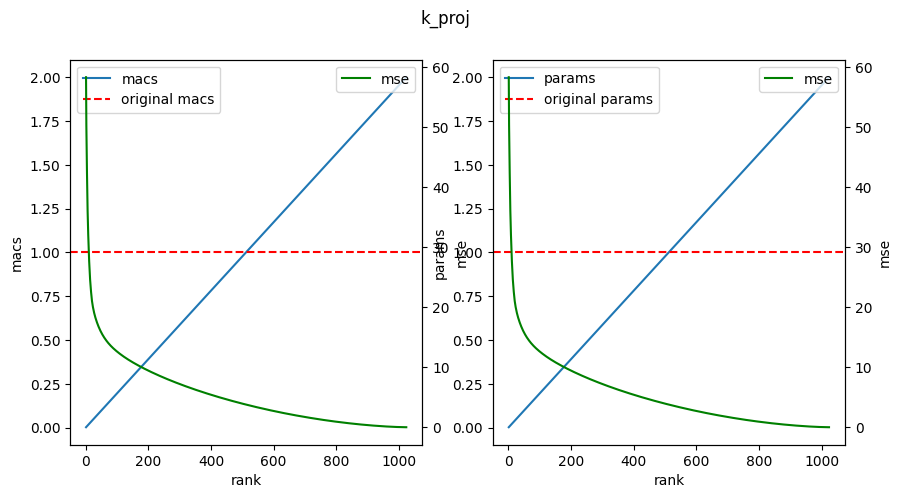

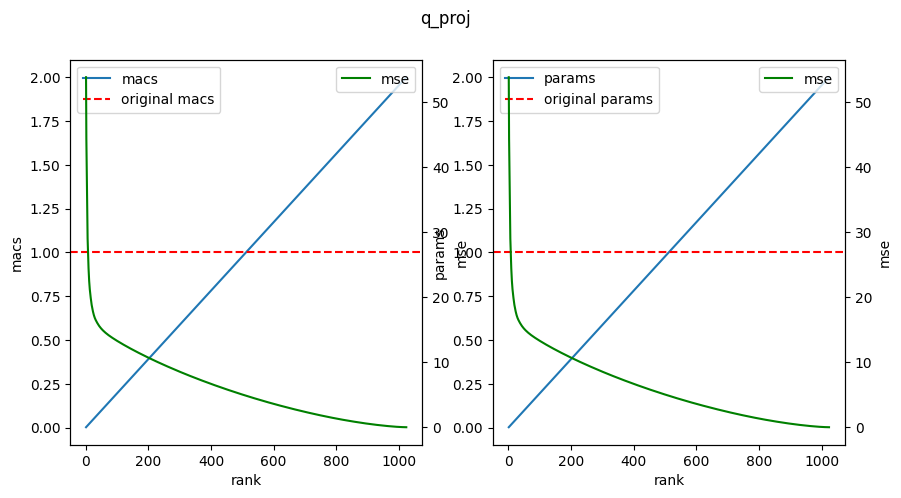

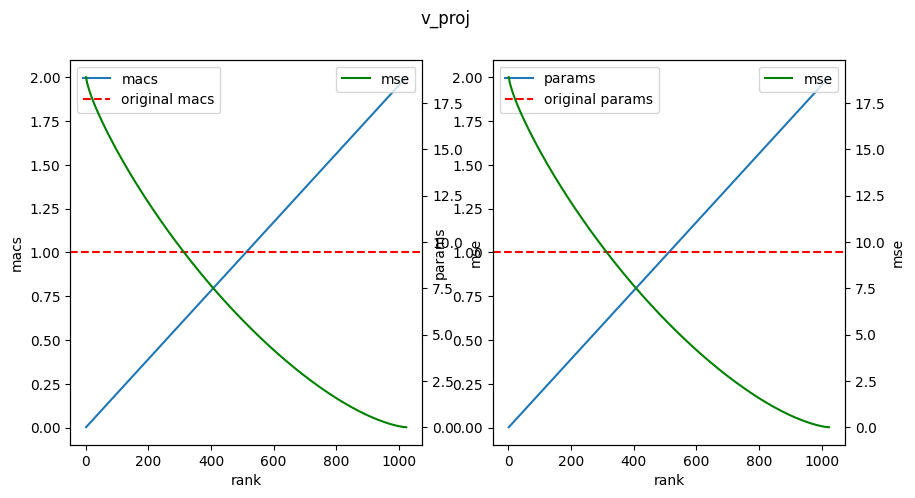

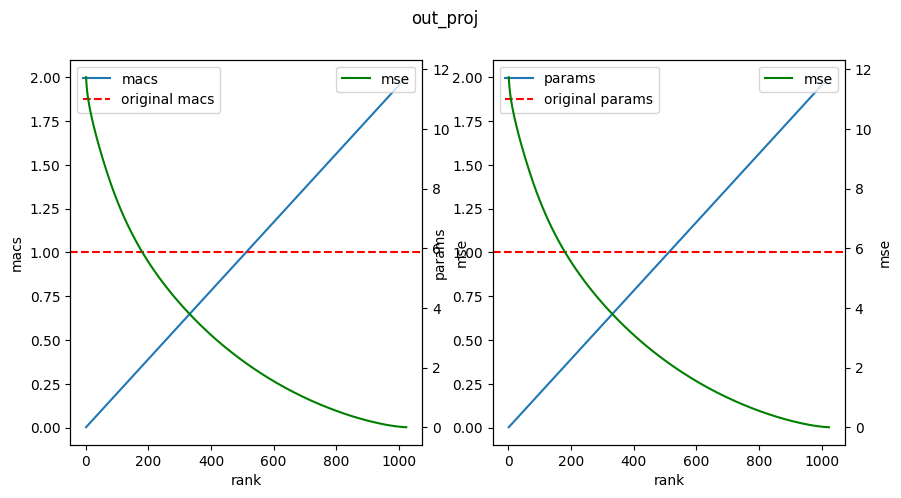

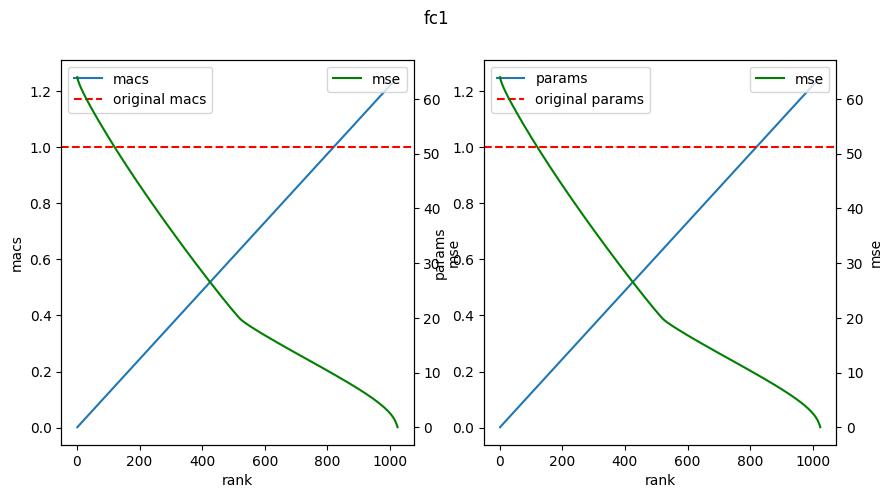

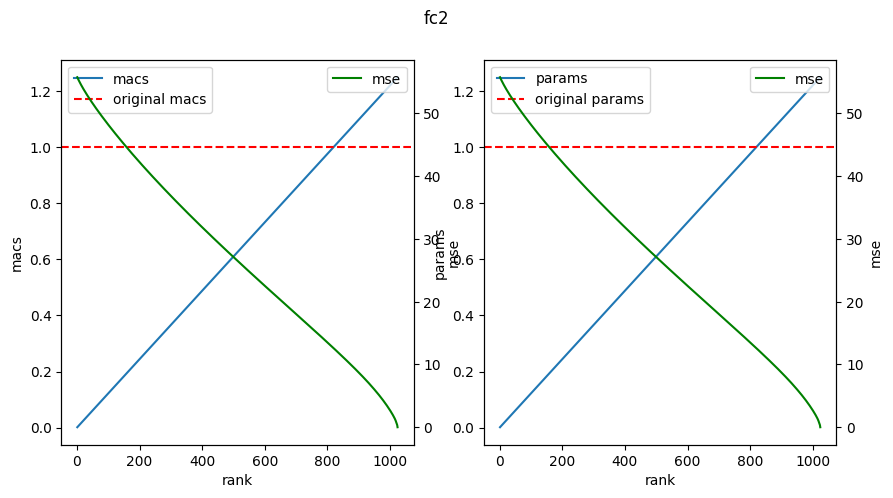

In [8]:
# plot k_proj
plot_macs_mse(atten_block.k_proj, title="k_proj")
plot_macs_mse(atten_block.q_proj, title="q_proj")
plot_macs_mse(atten_block.v_proj, title="v_proj")
plot_macs_mse(atten_block.out_proj, title="out_proj")
plot_macs_mse(model.decoder.layers[0].fc1, title="fc1")
plot_macs_mse(model.decoder.layers[0].fc2, title="fc2")

decoder_layer_0
decoder_layer_1
decoder_layer_2
decoder_layer_3
decoder_layer_4
decoder_layer_5
decoder_layer_6
decoder_layer_7
decoder_layer_8
decoder_layer_9
decoder_layer_10
decoder_layer_11
decoder_layer_12
decoder_layer_13
decoder_layer_14
decoder_layer_15
decoder_layer_16
decoder_layer_17
decoder_layer_18
decoder_layer_19
decoder_layer_20


/home/zkr12123/work/phd/llm/test_utils.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 3, figsize=(15, 10))


decoder_layer_21
decoder_layer_22
decoder_layer_23


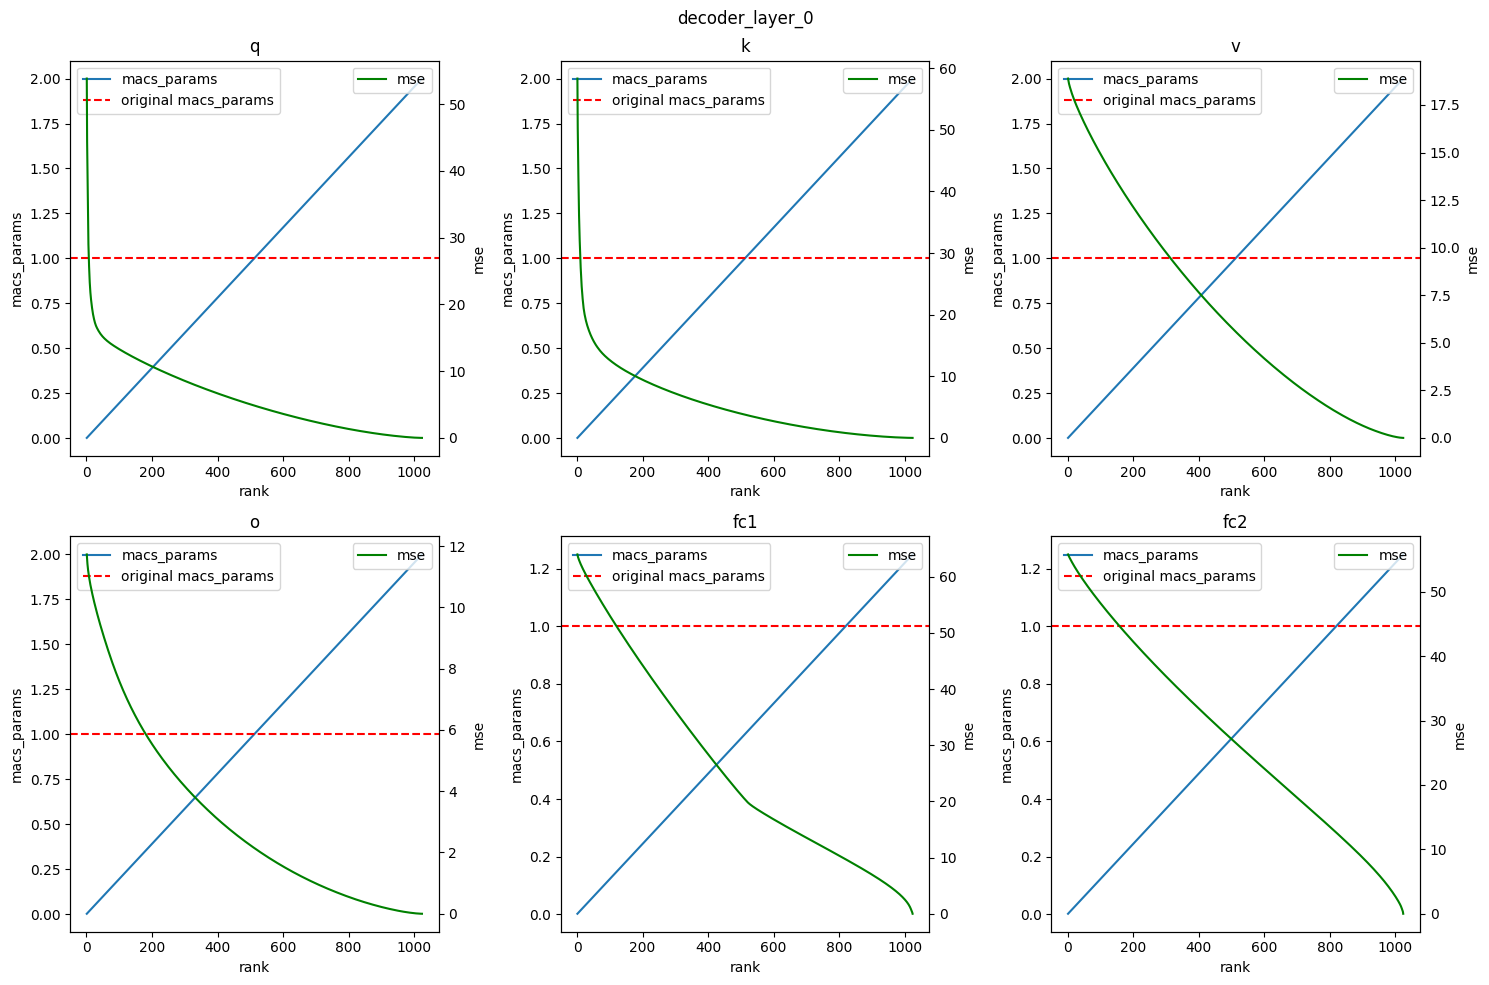

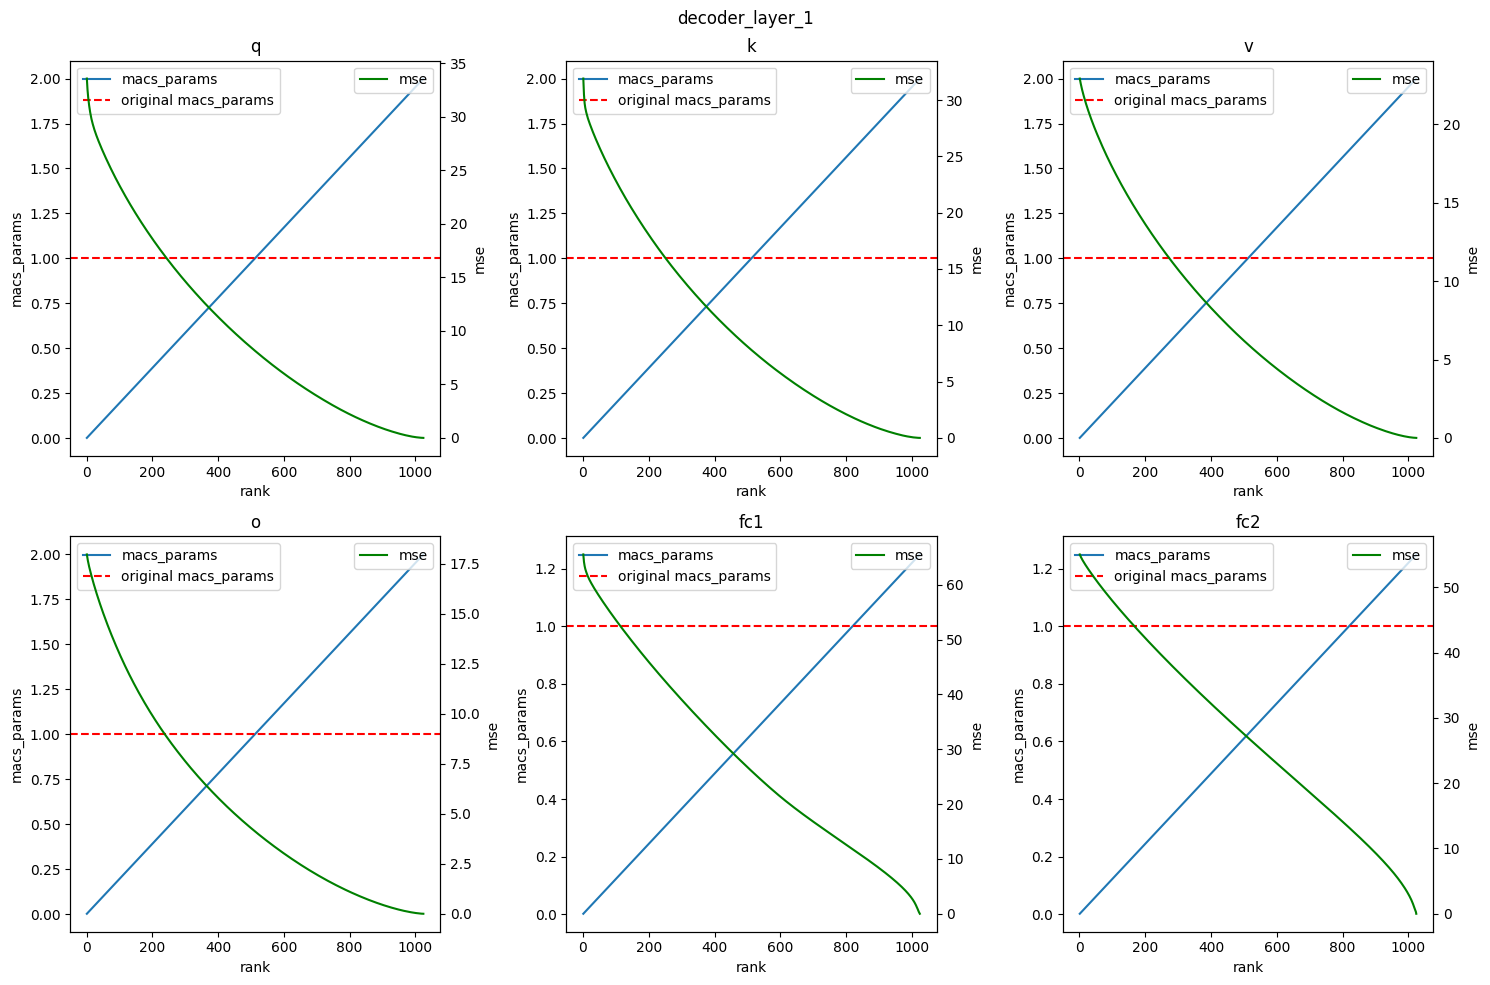

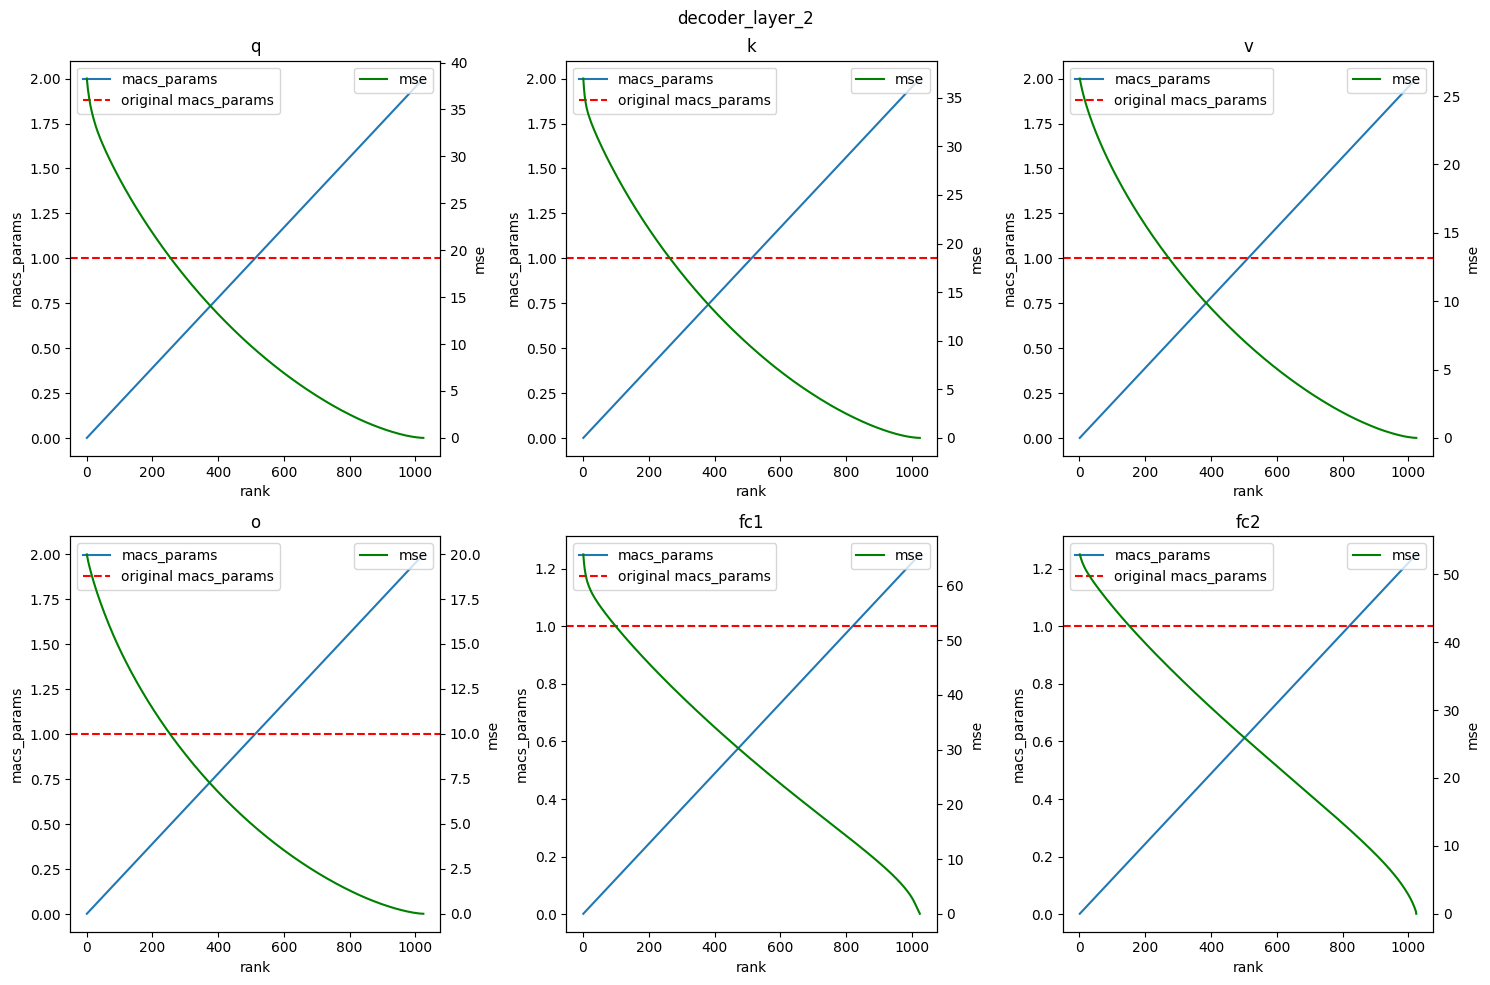

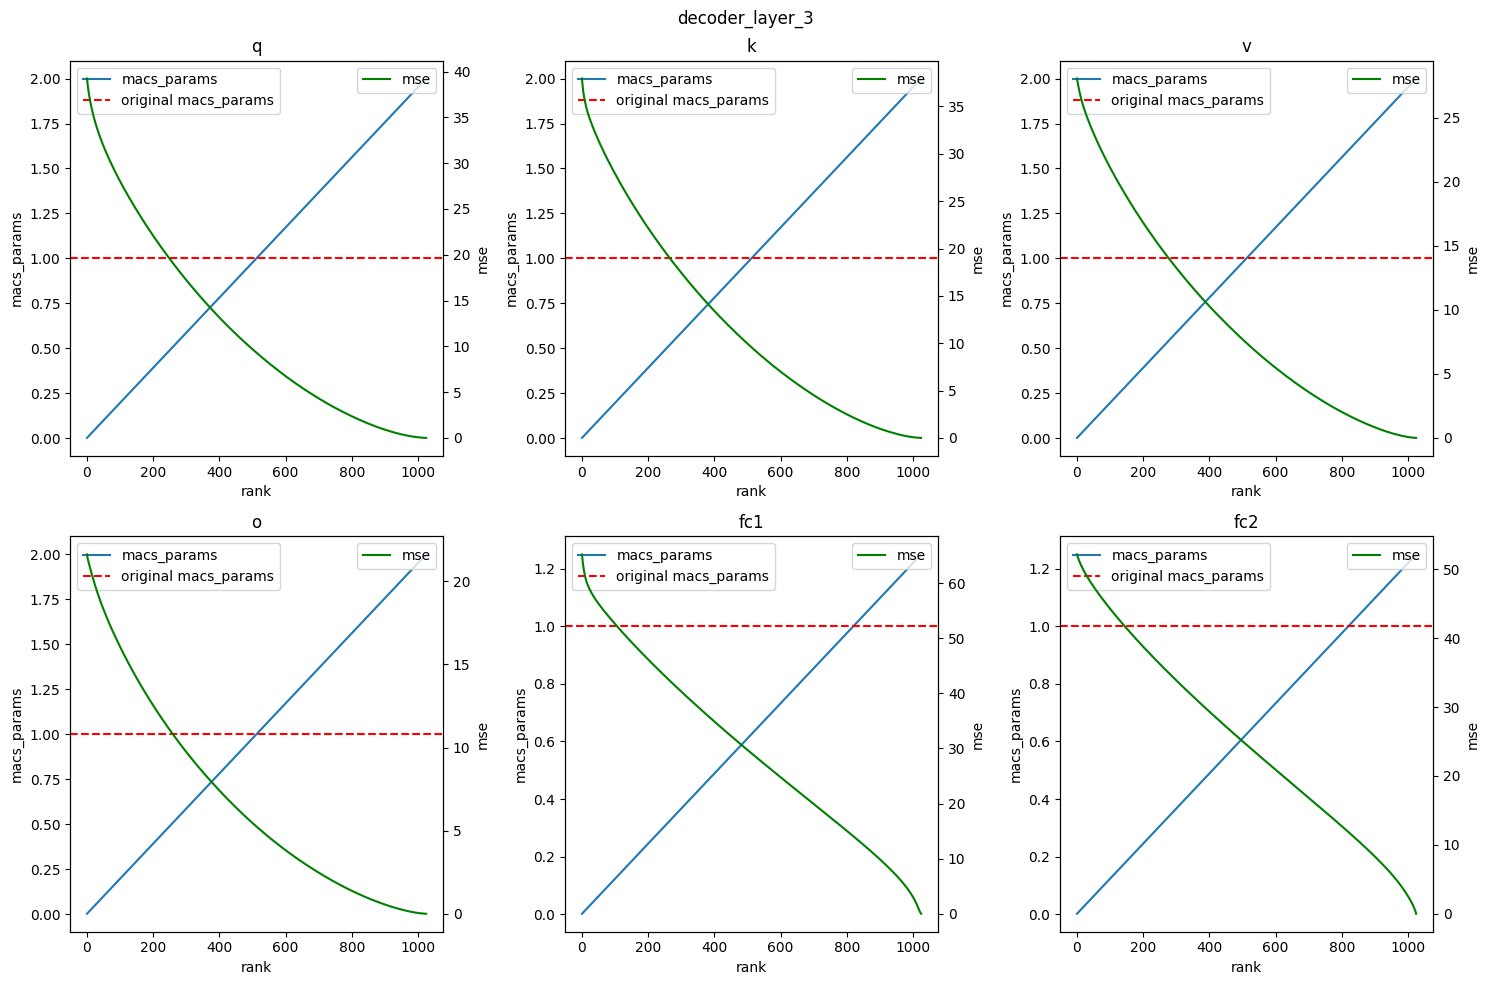

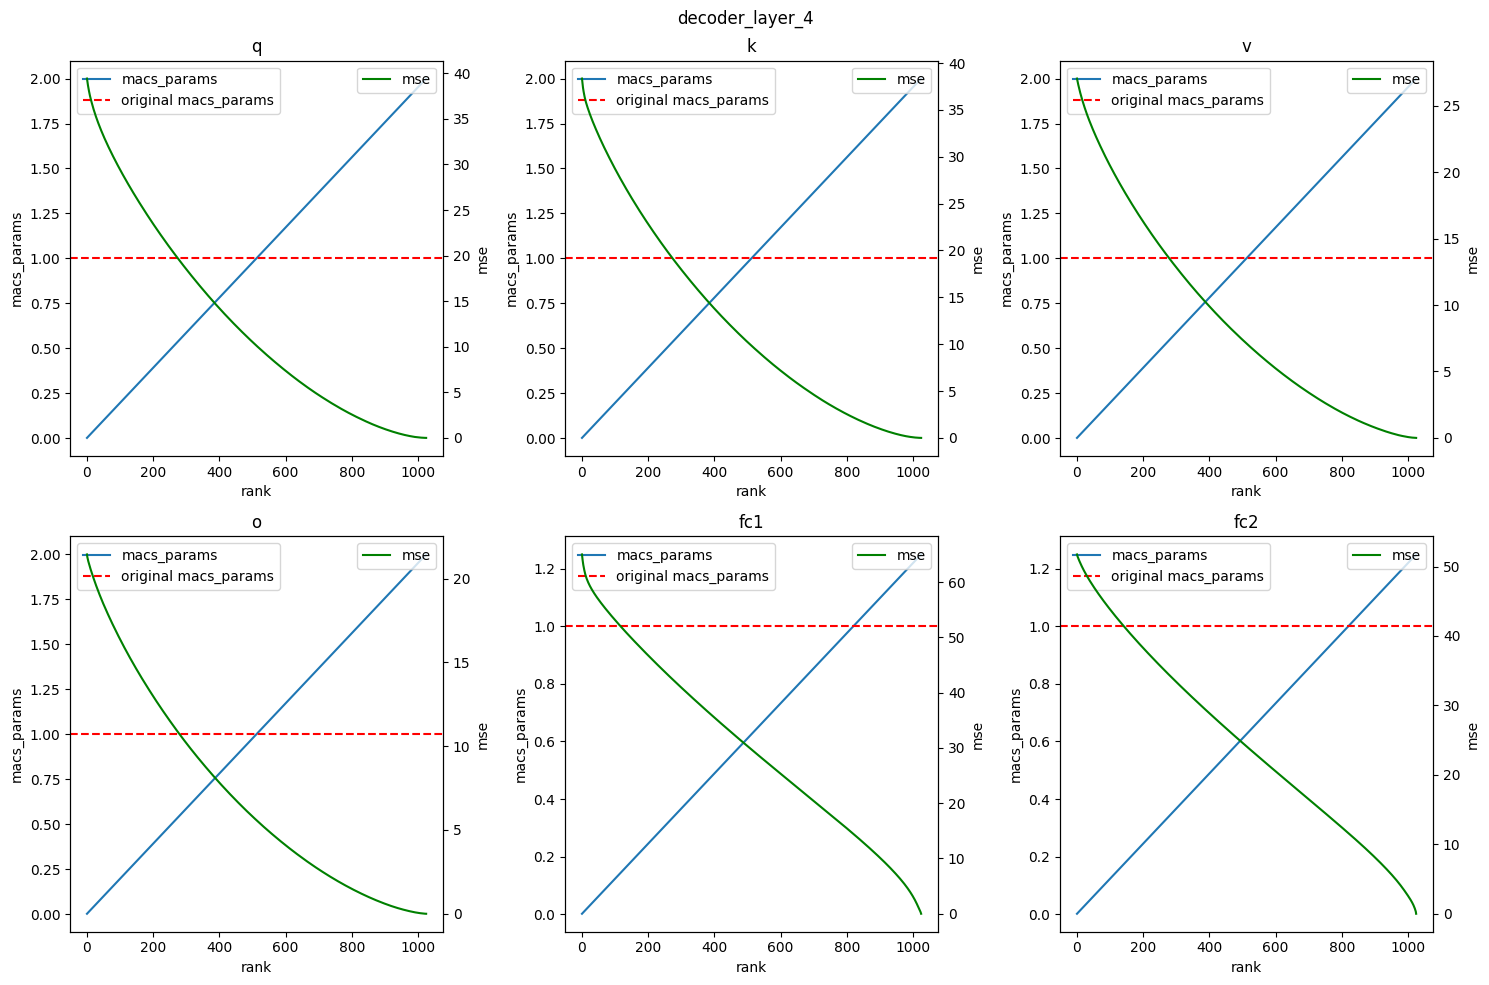

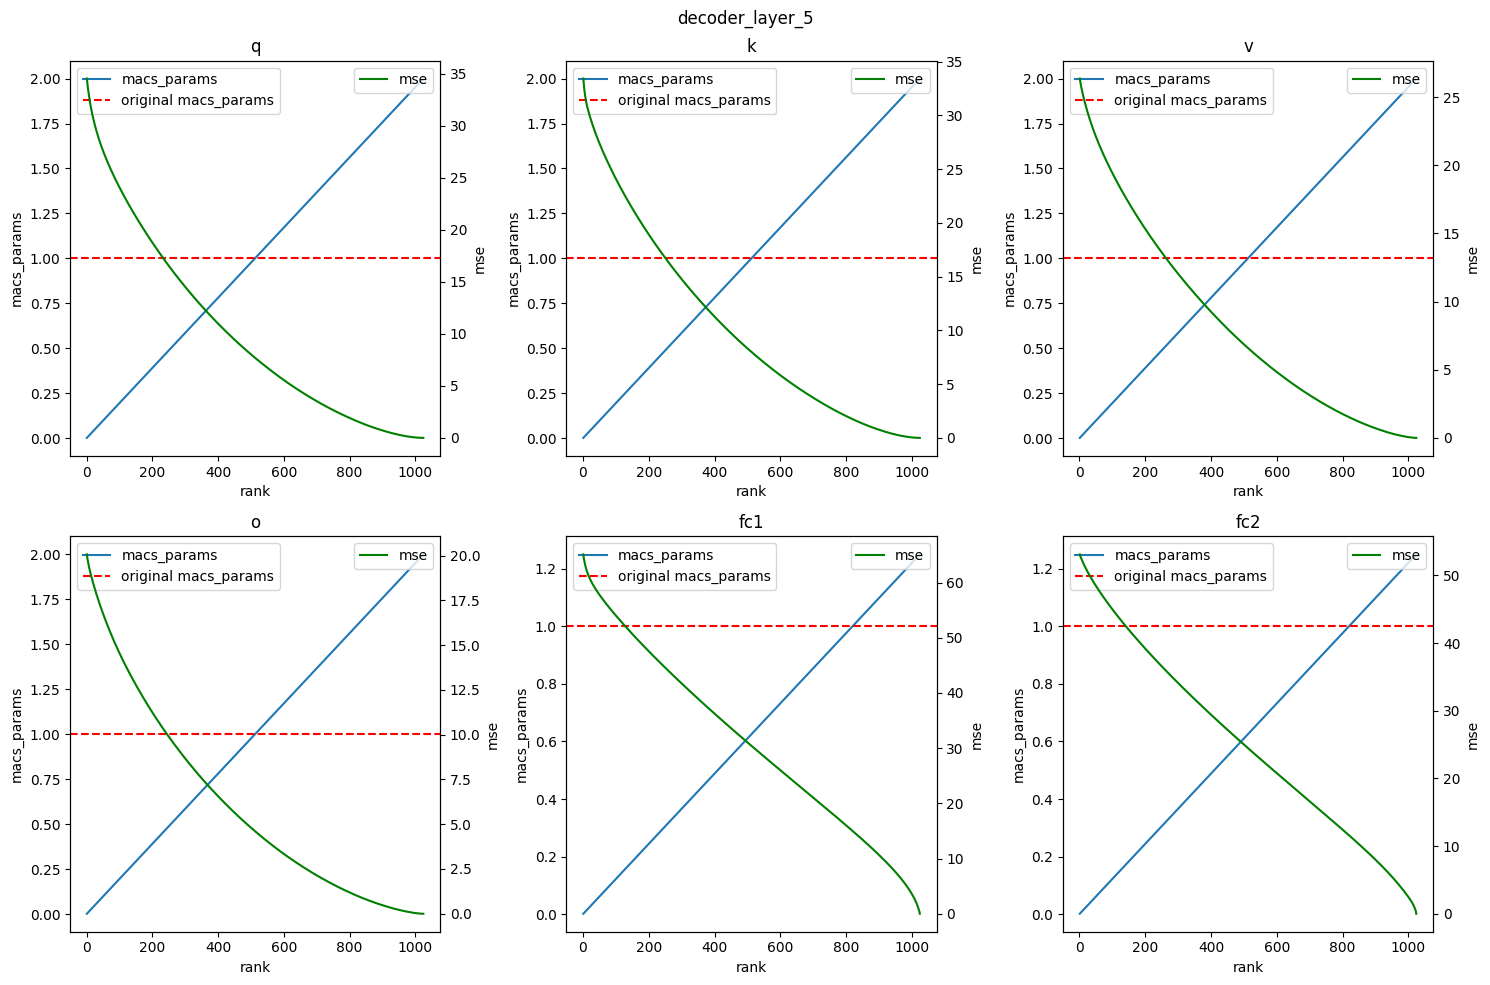

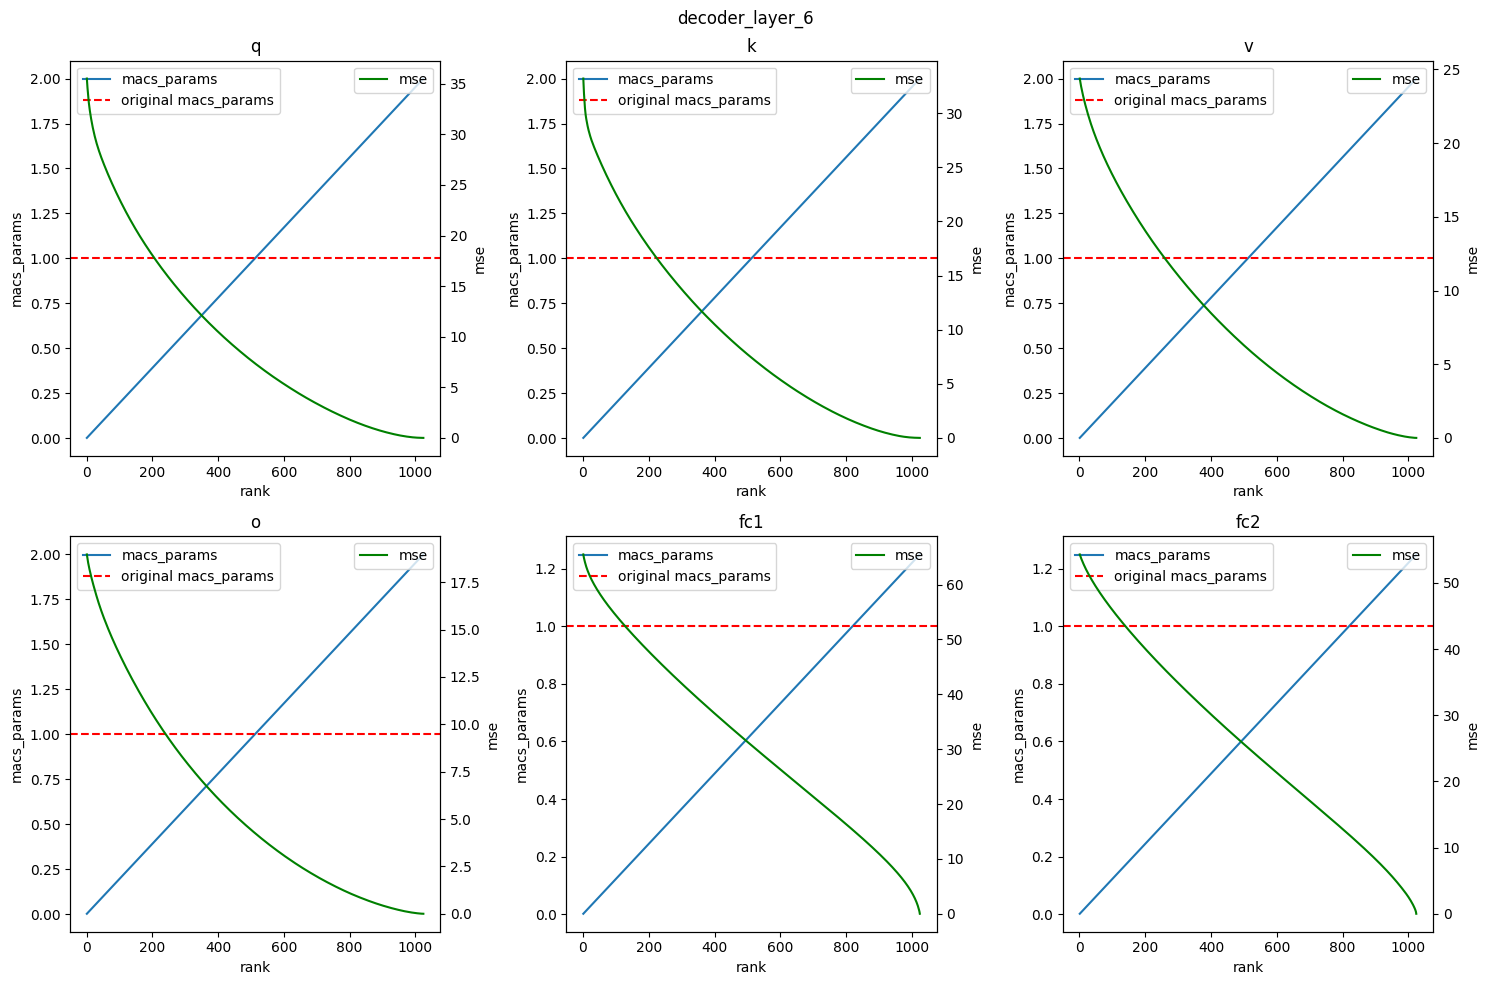

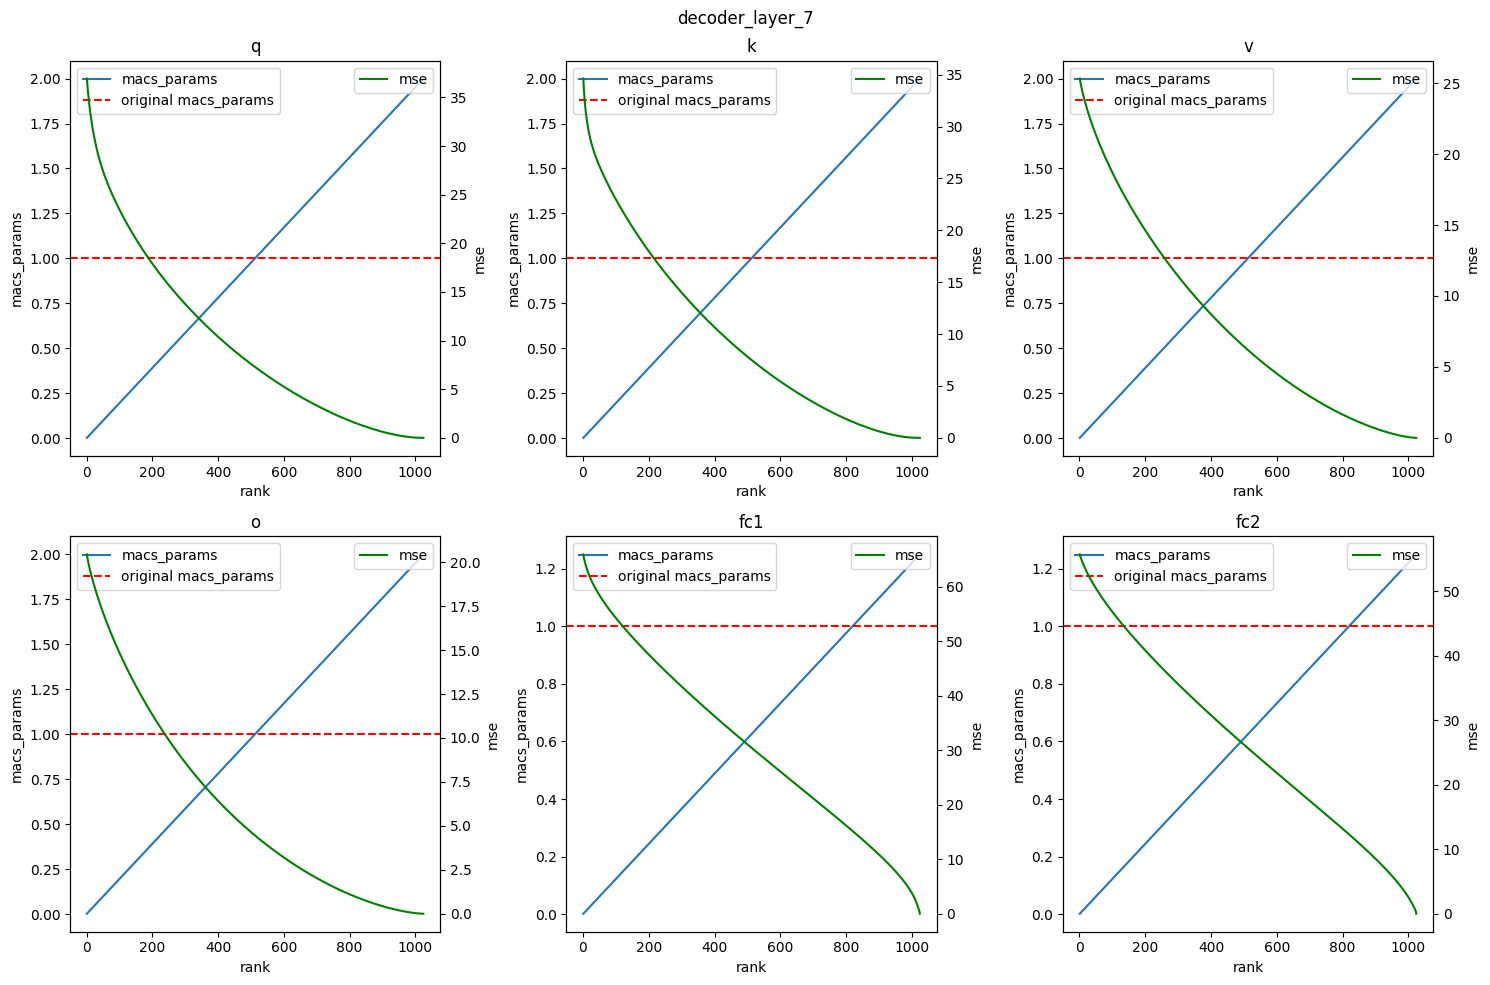

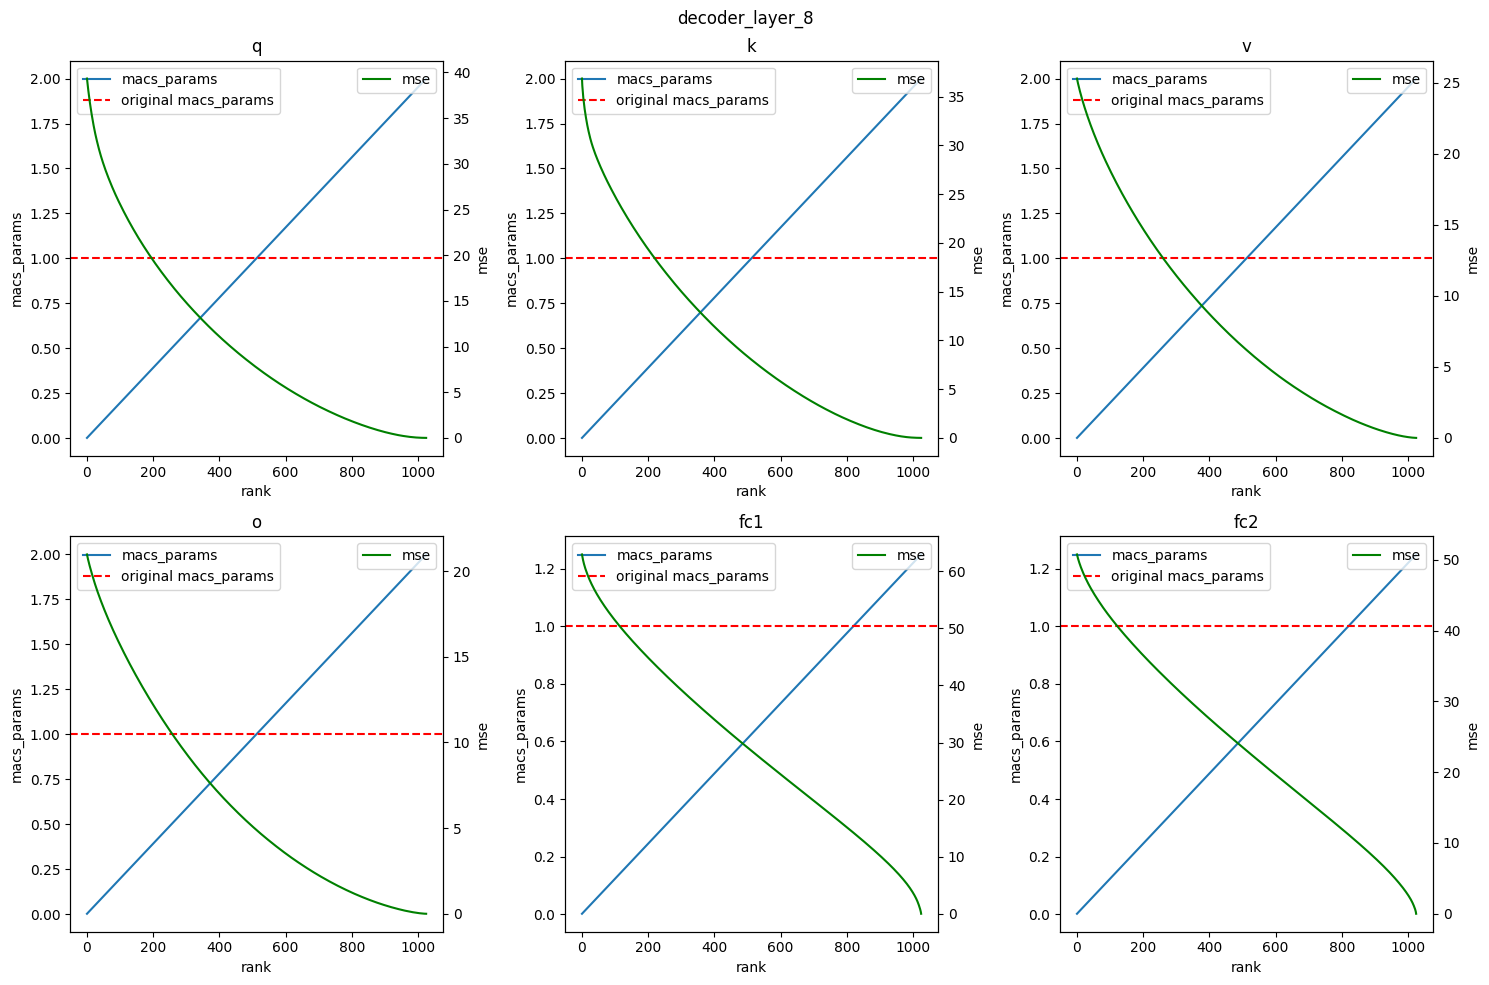

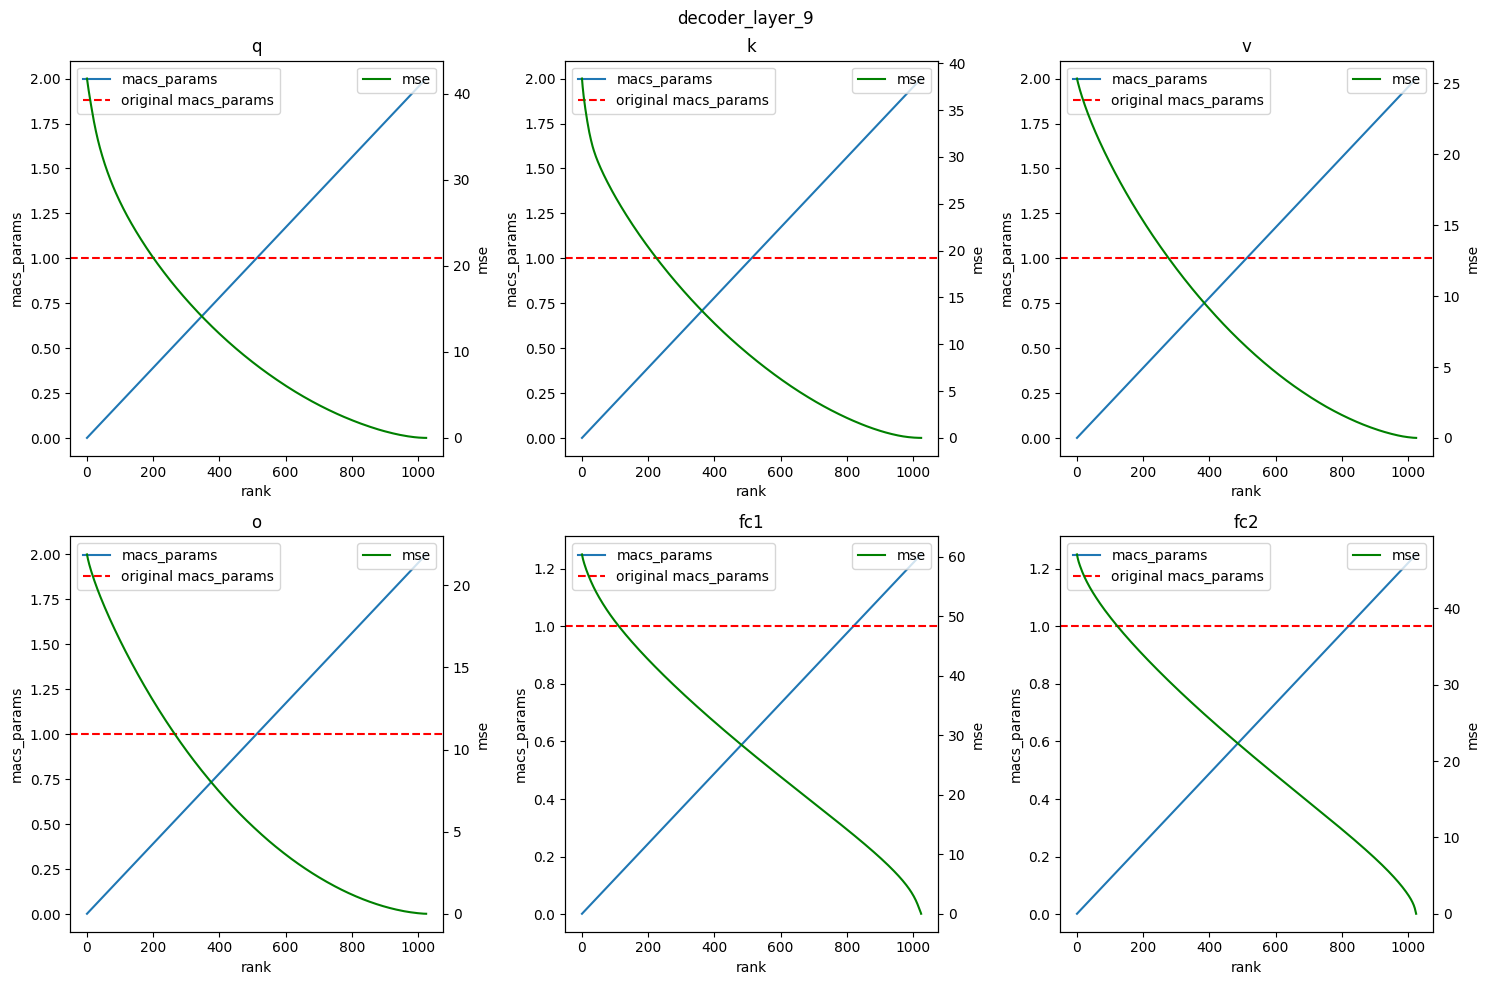

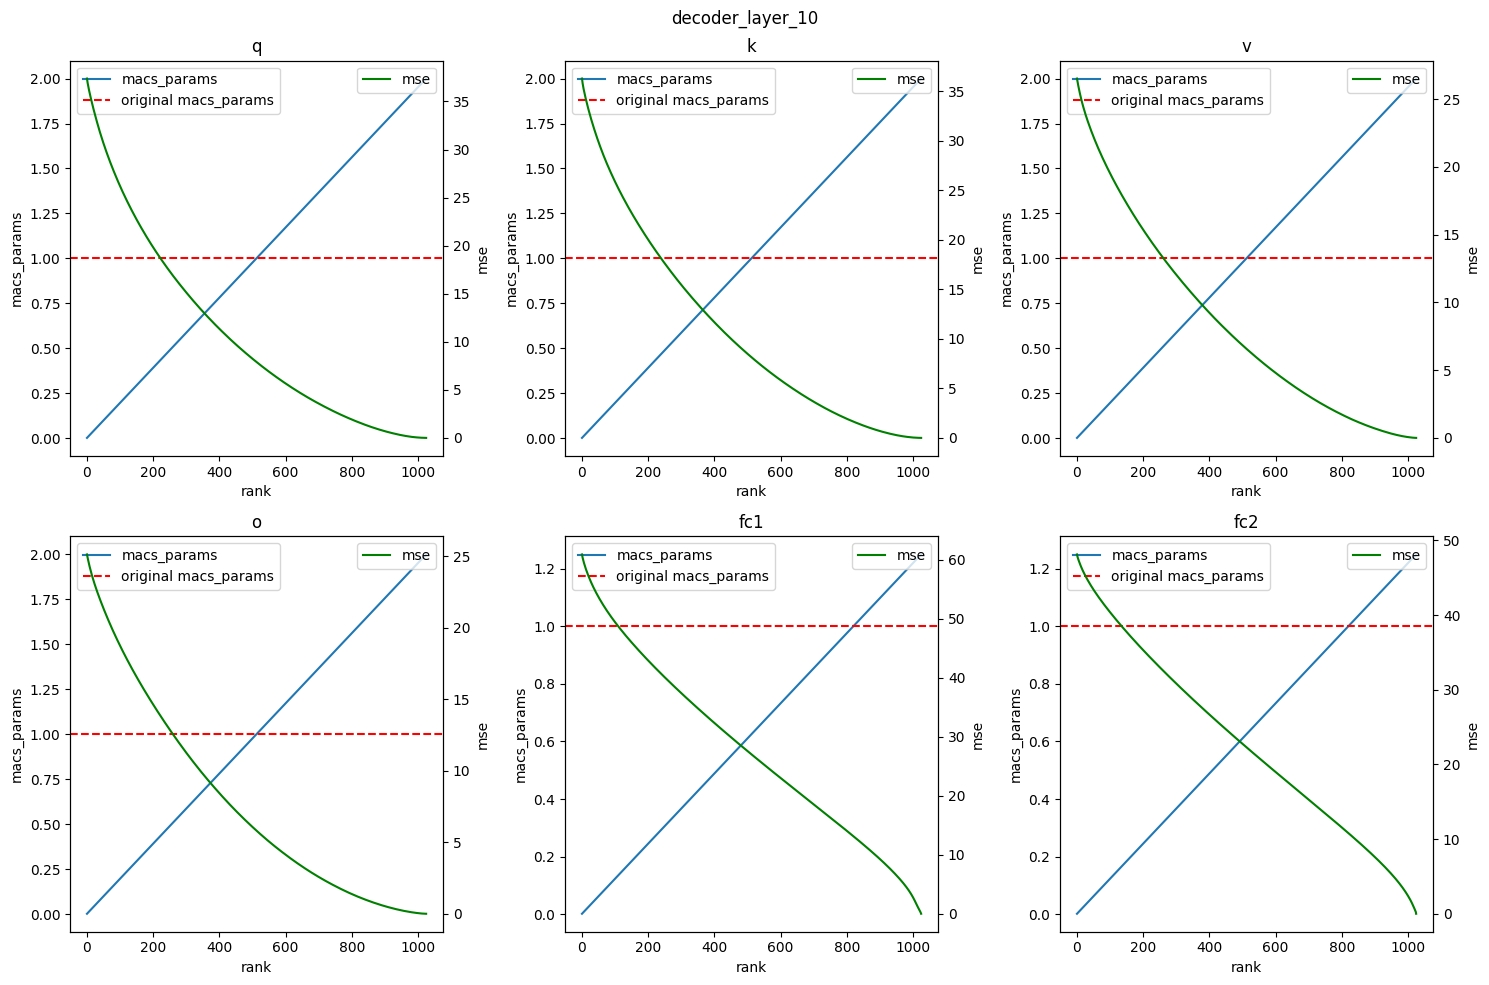

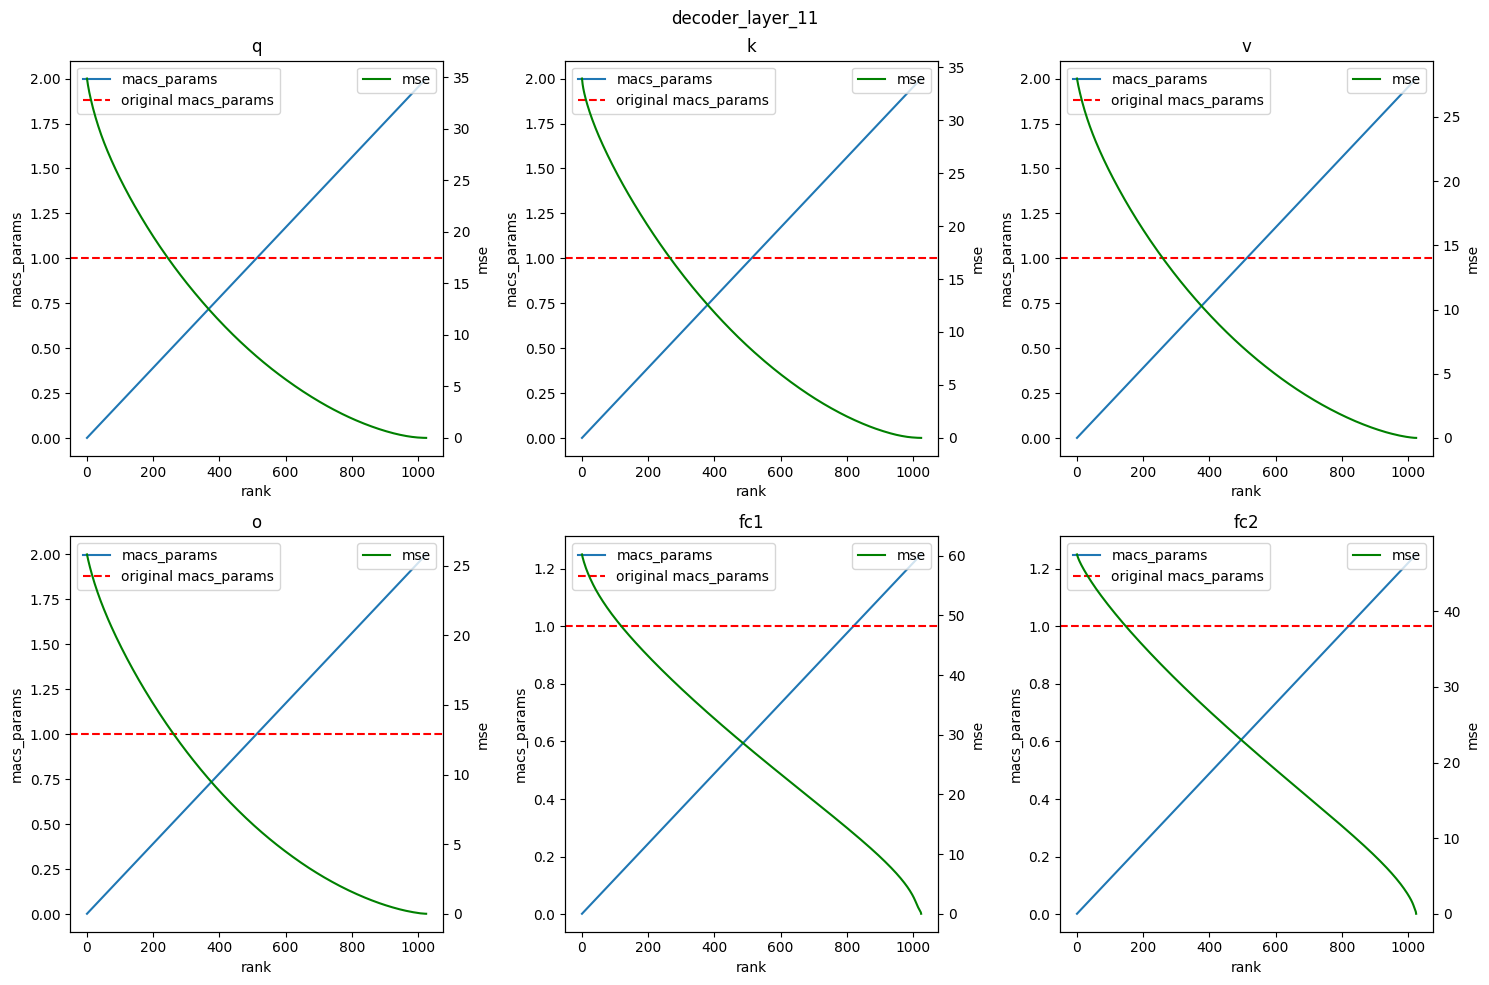

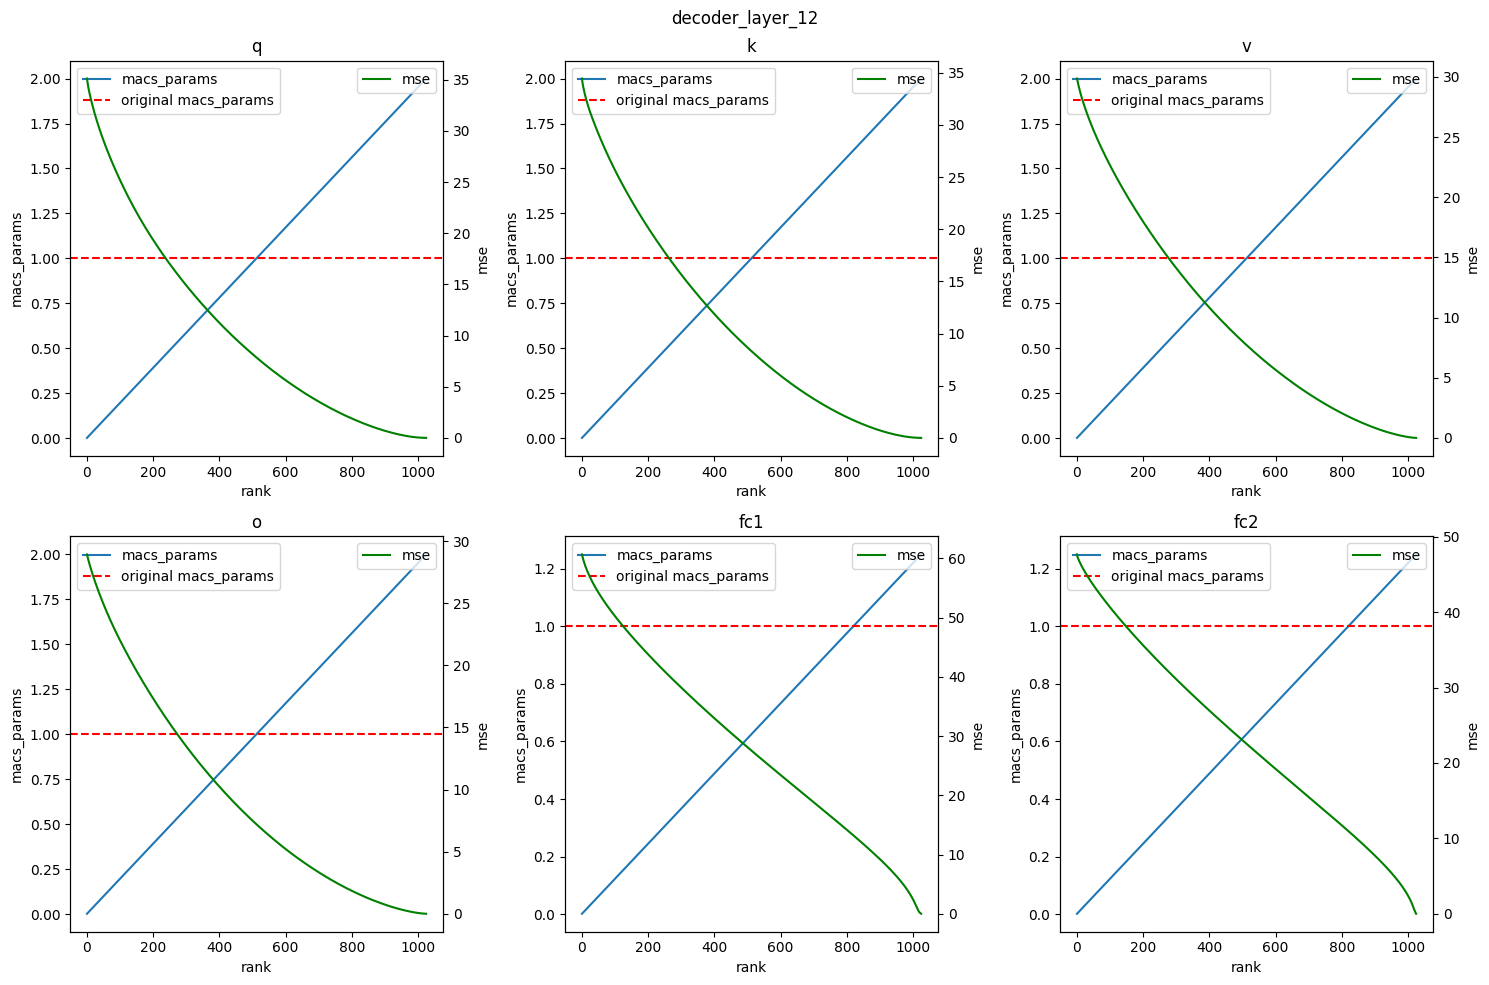

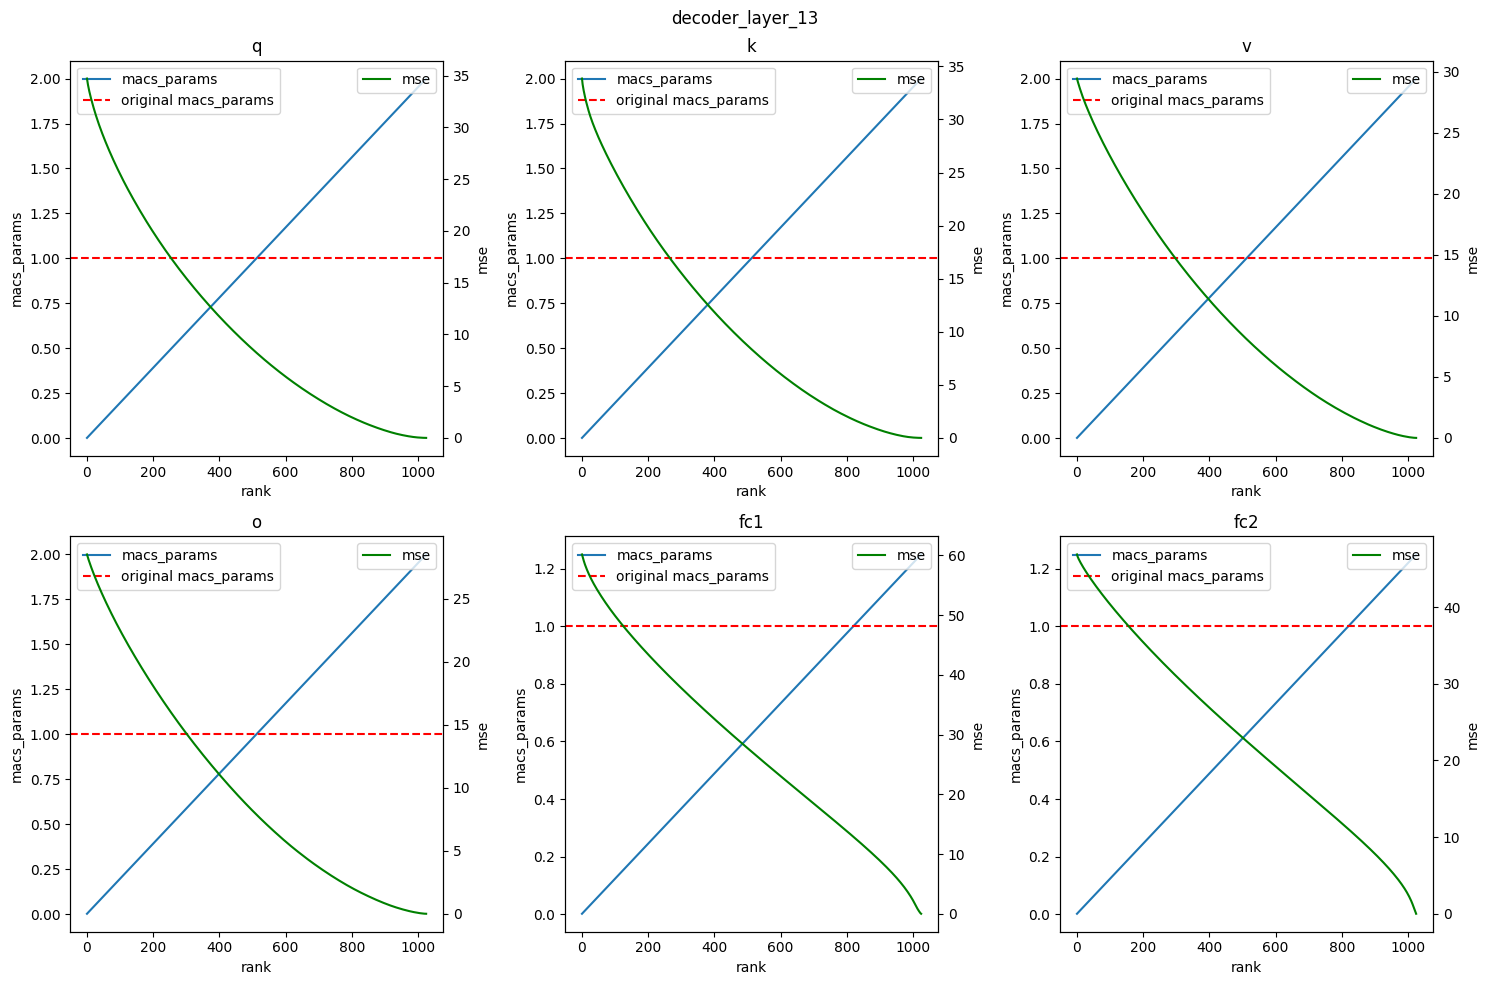

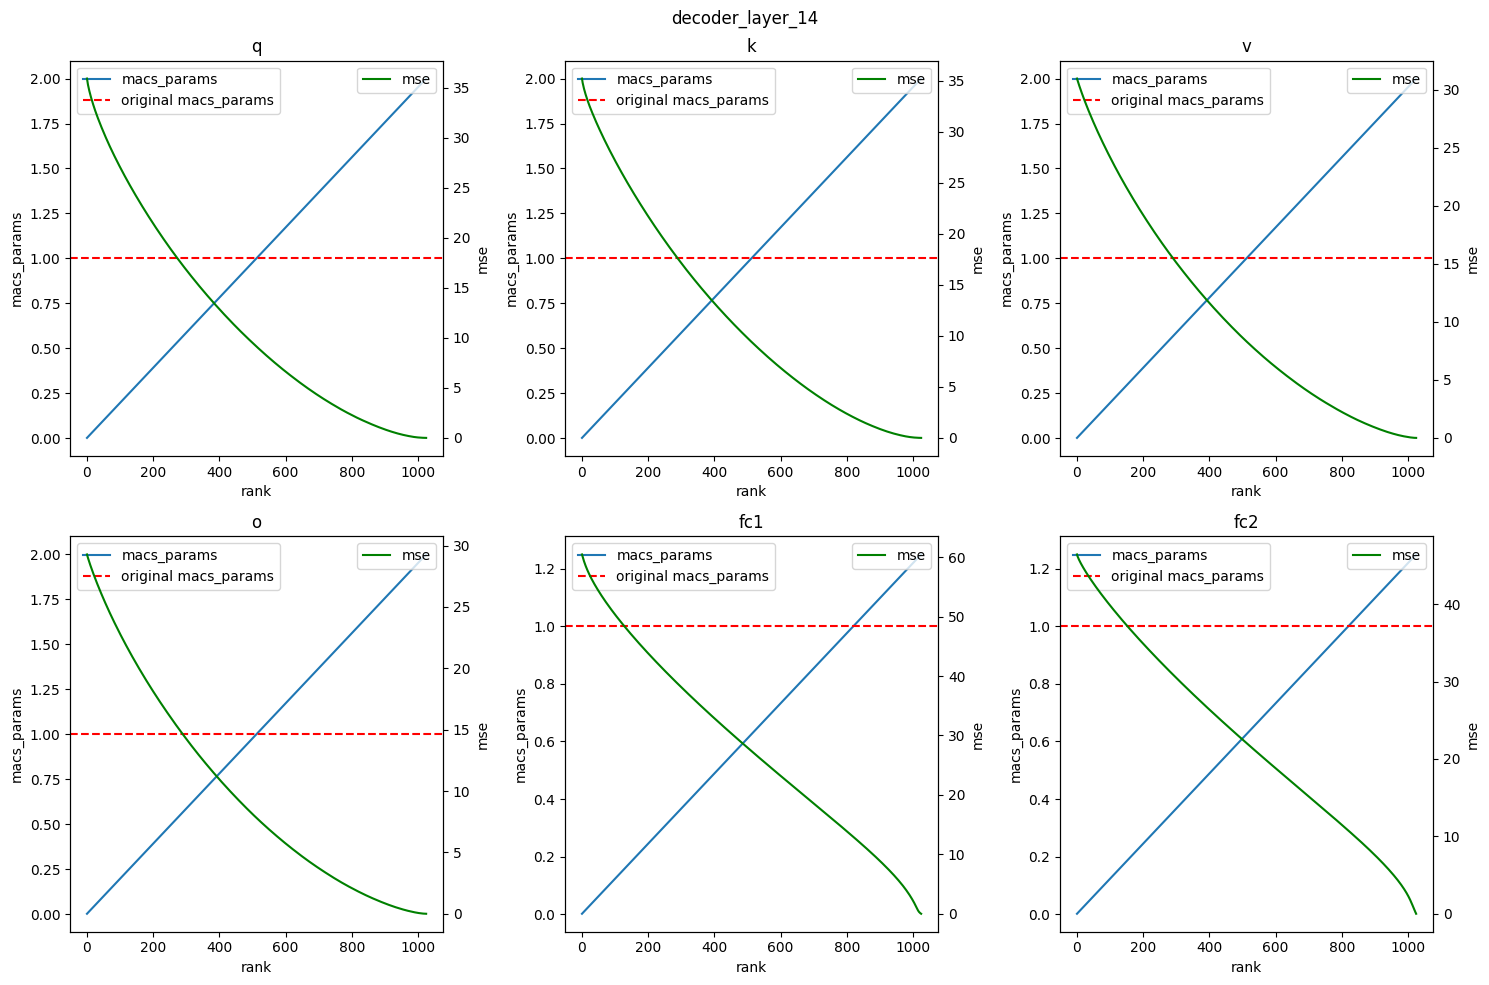

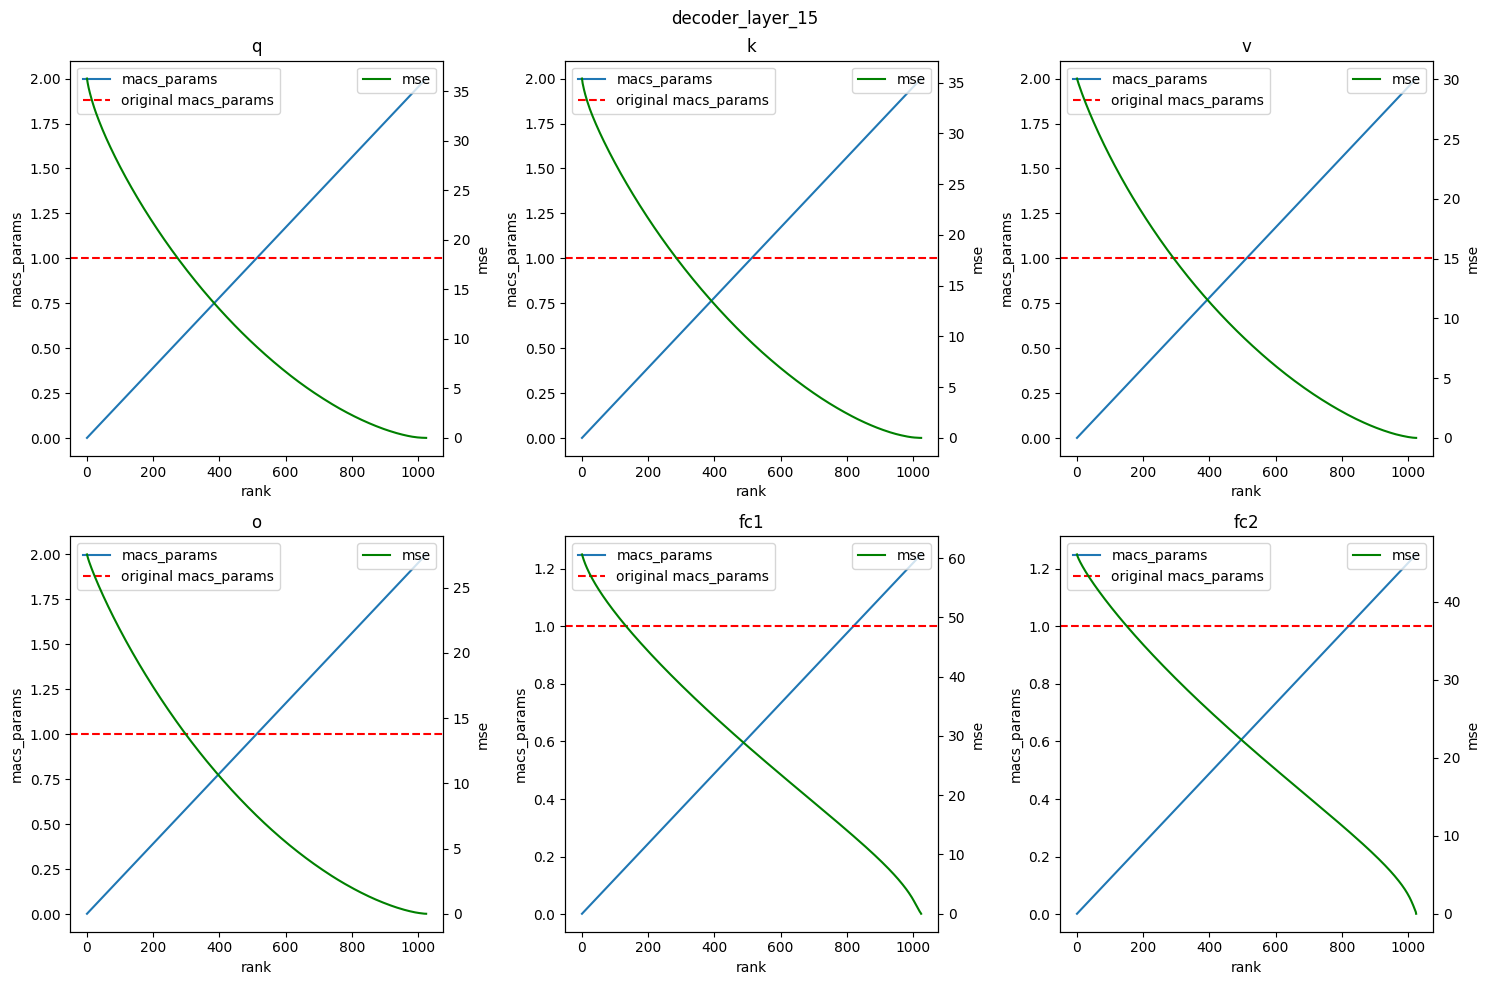

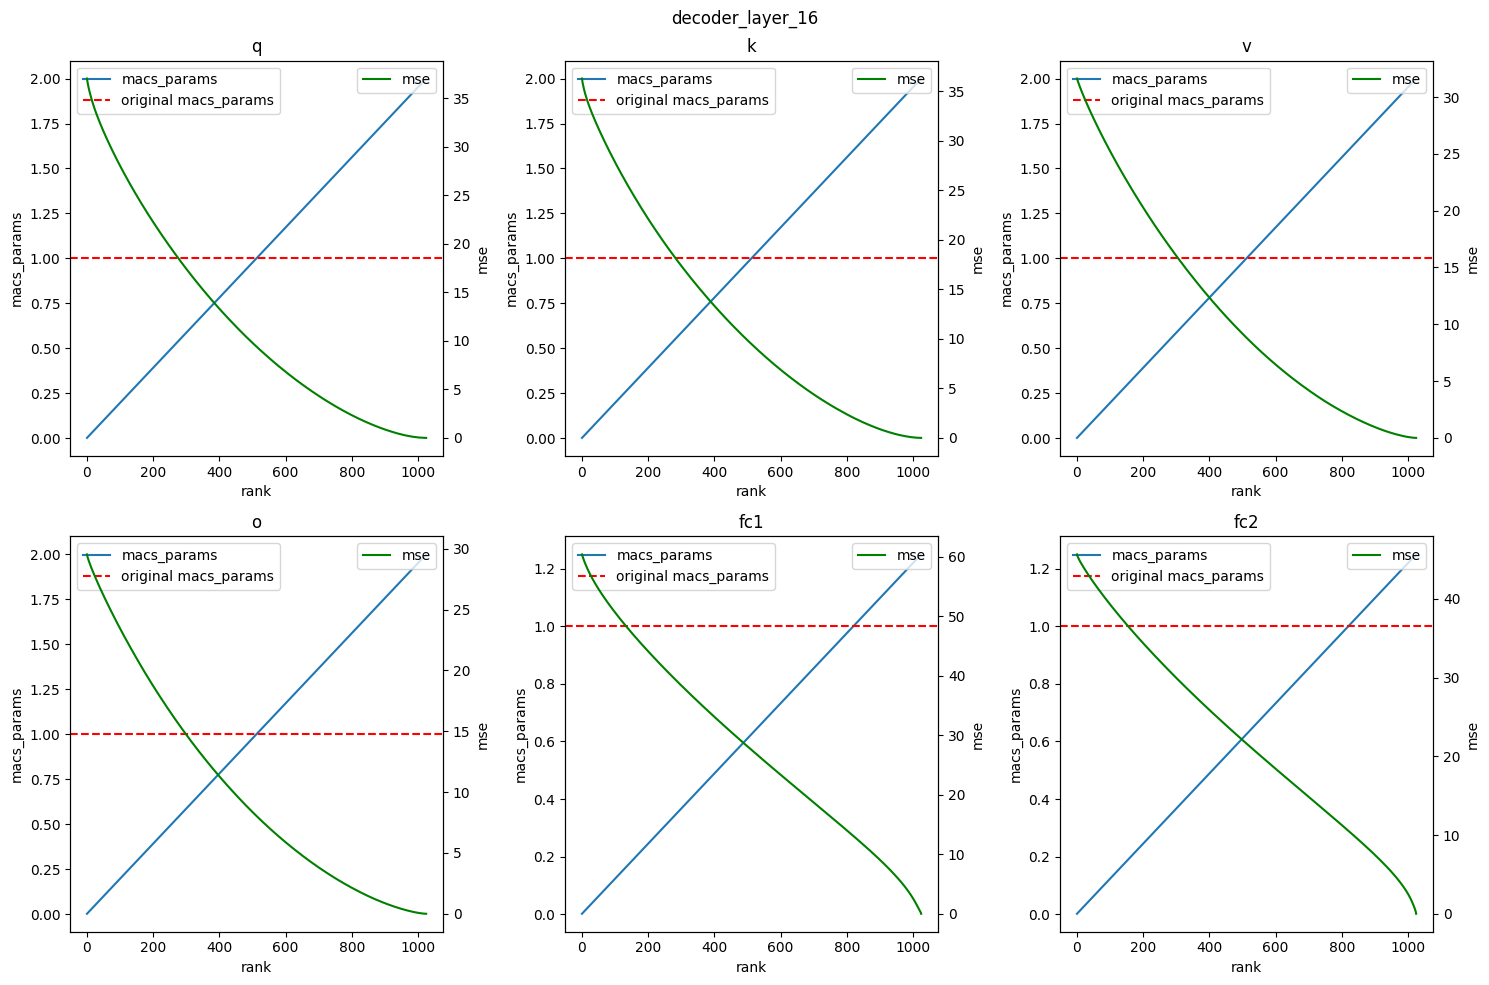

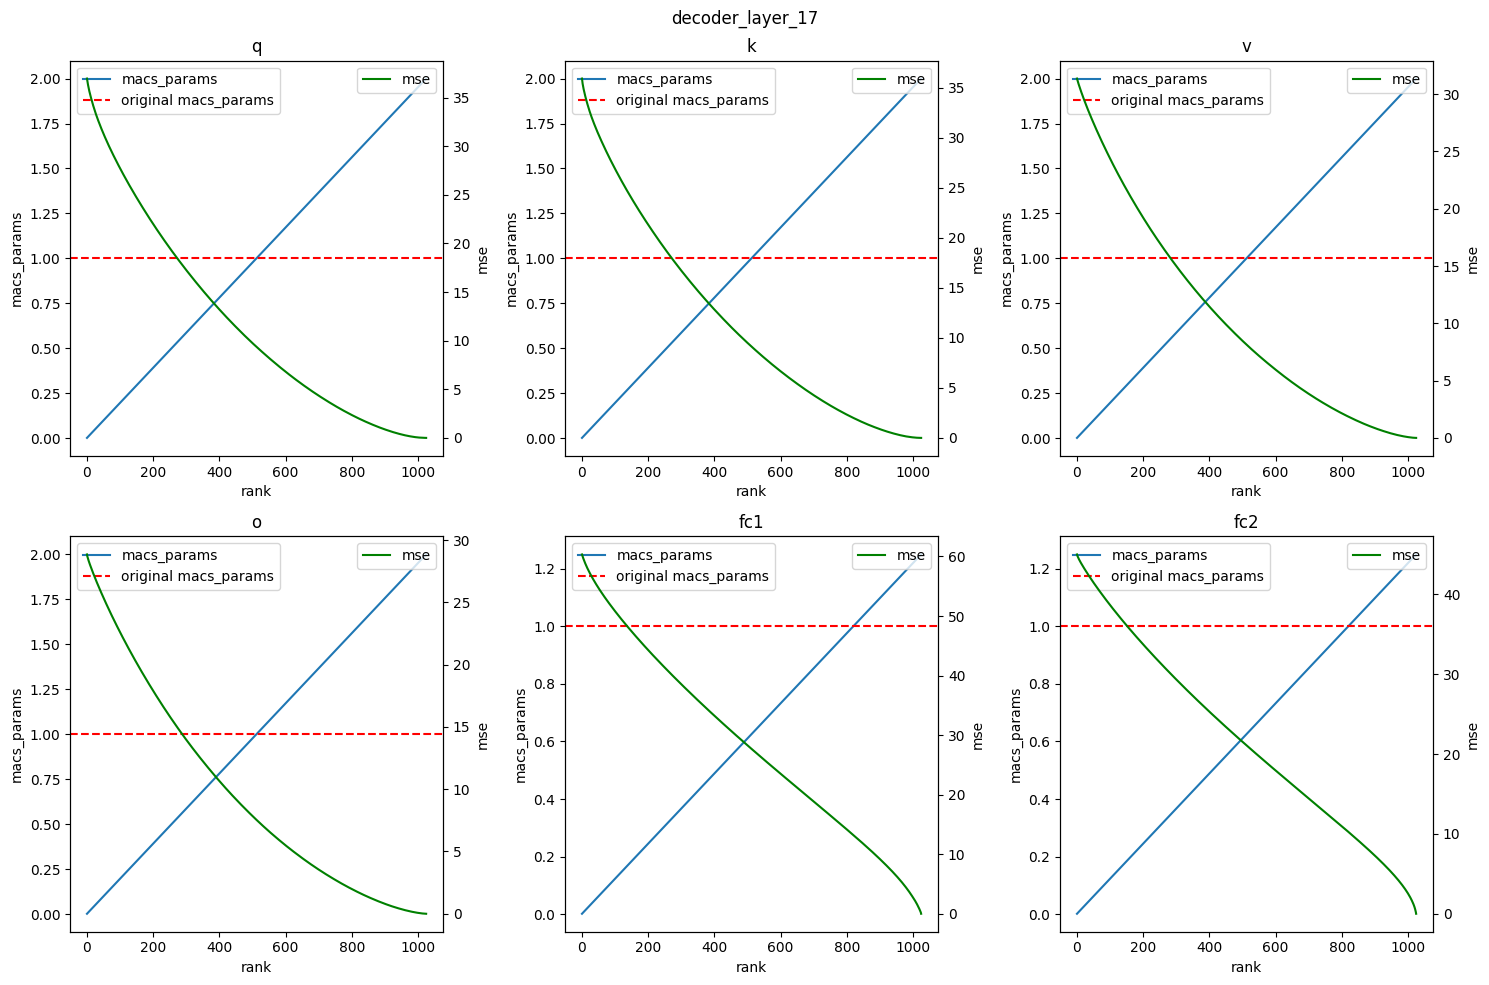

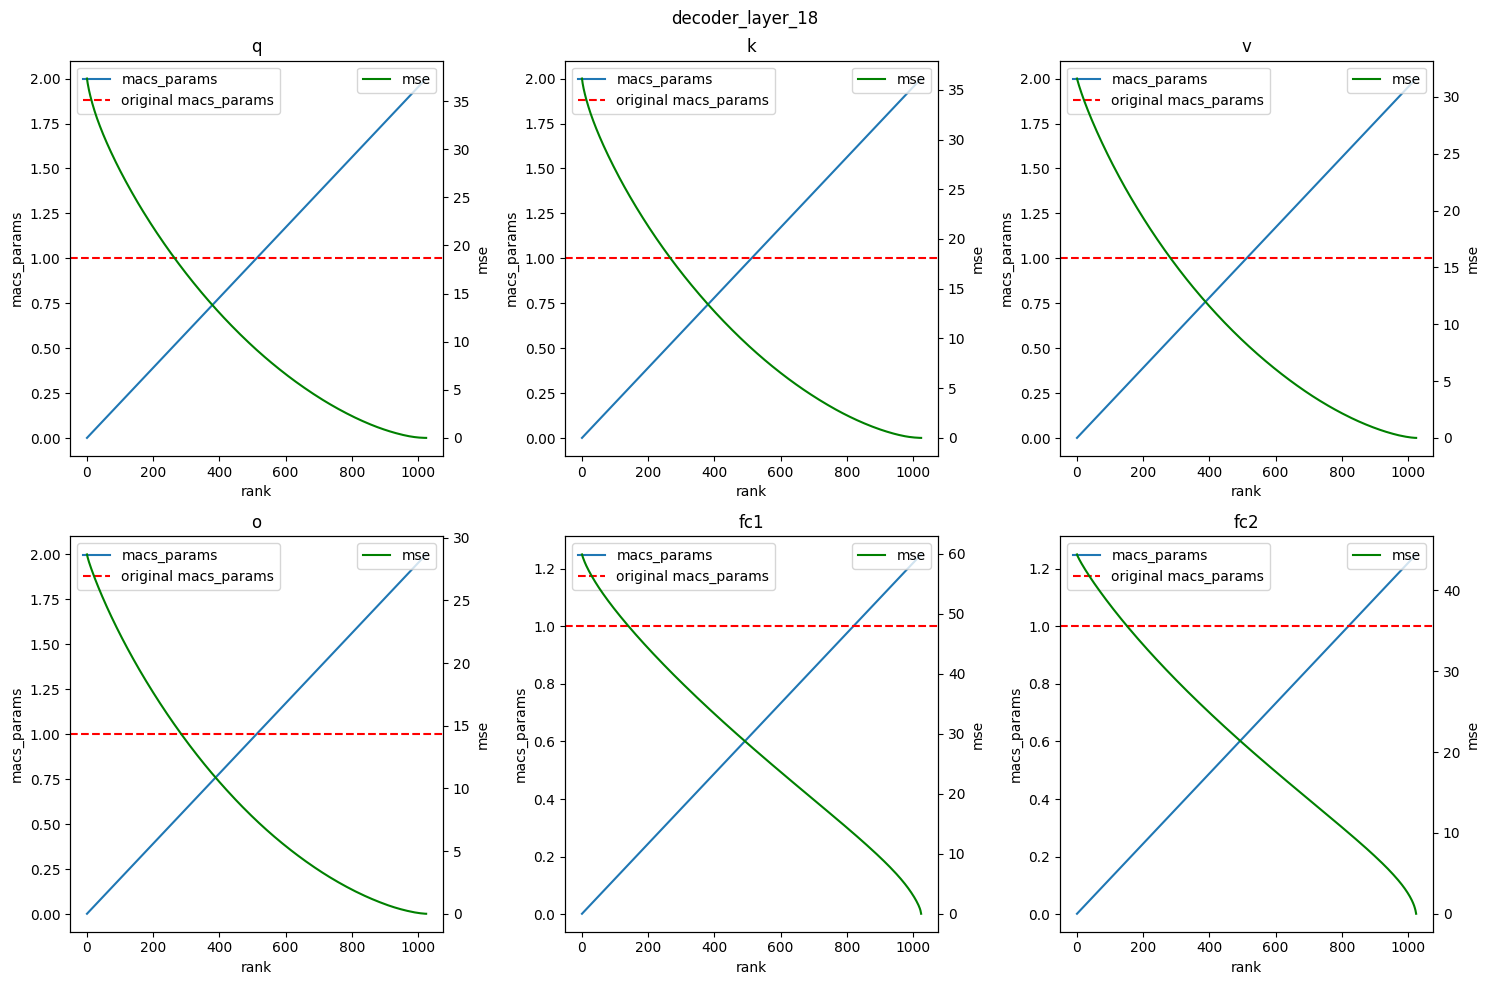

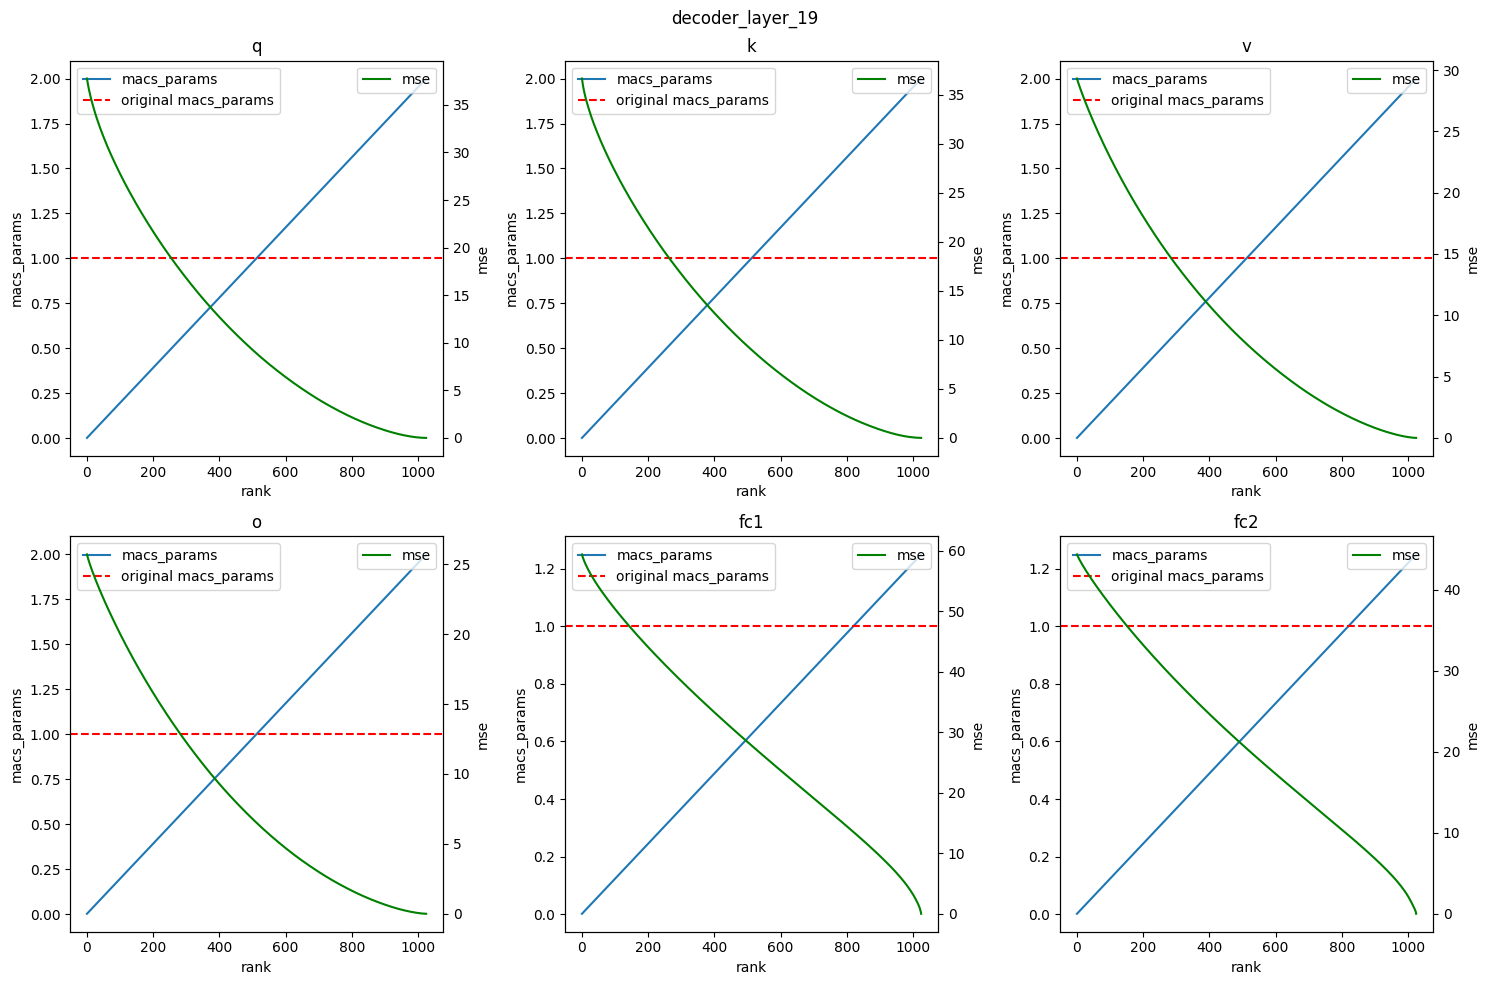

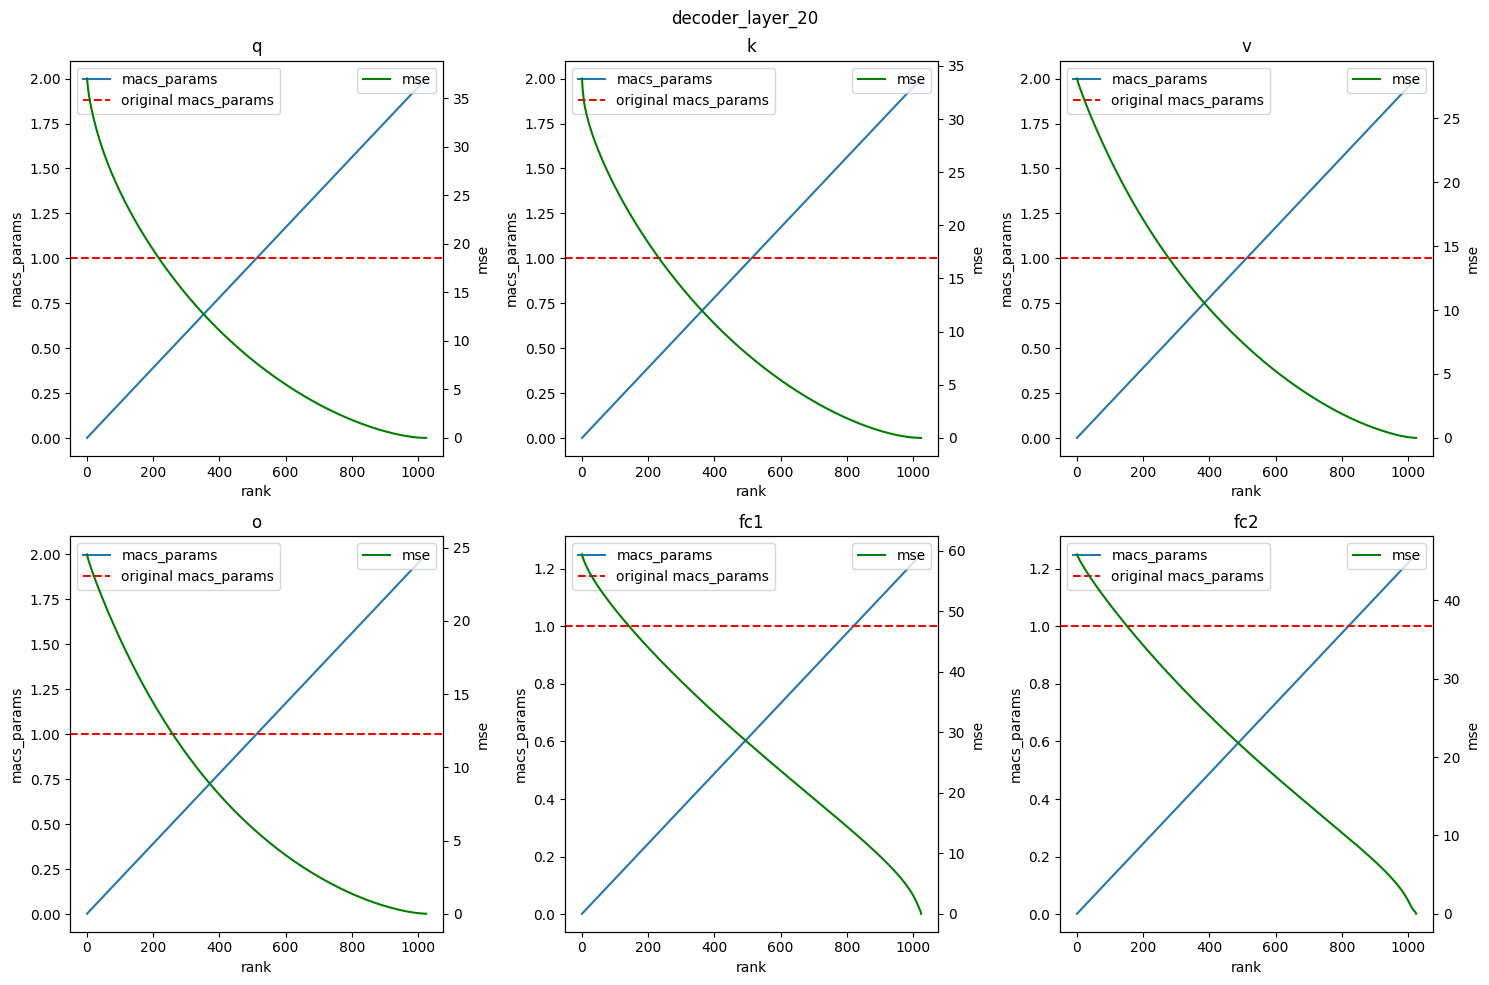

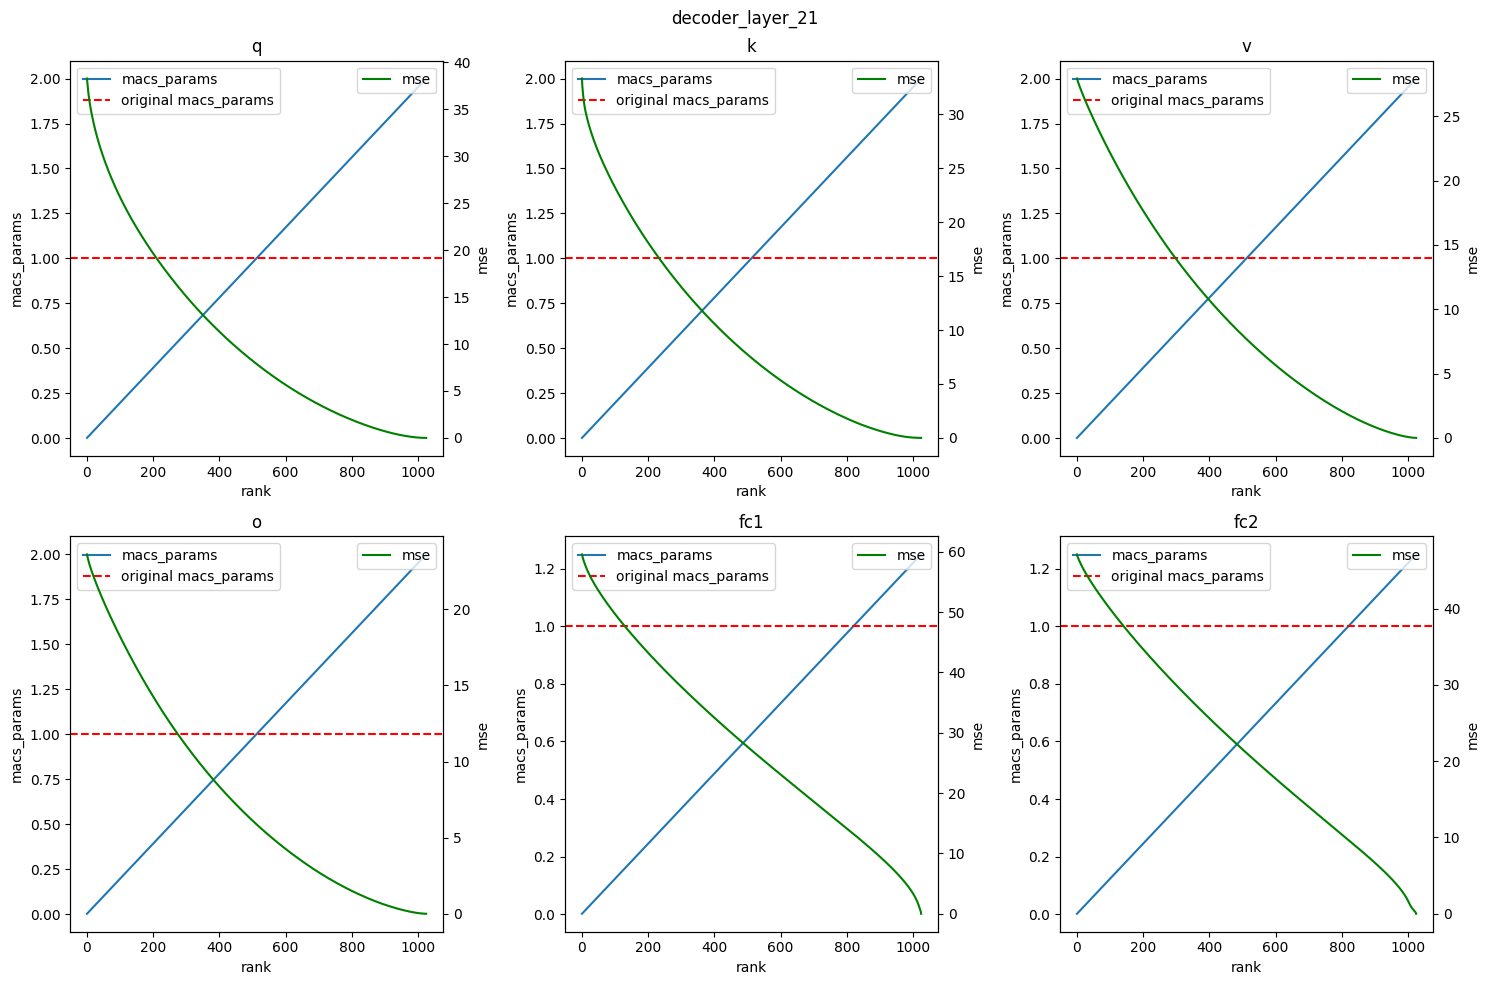

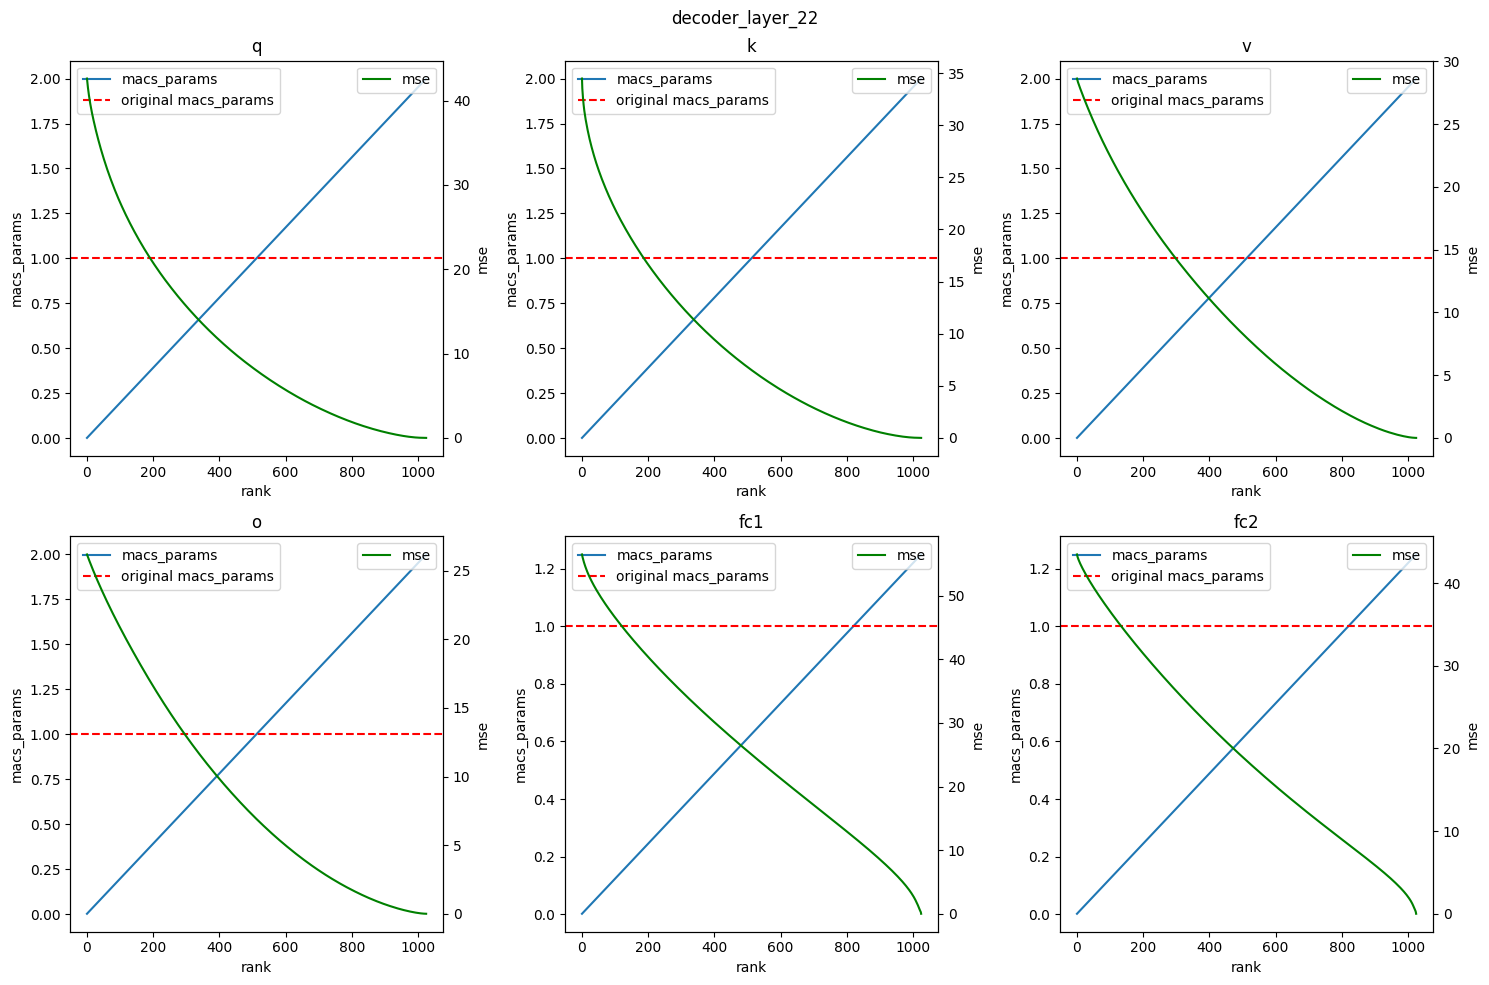

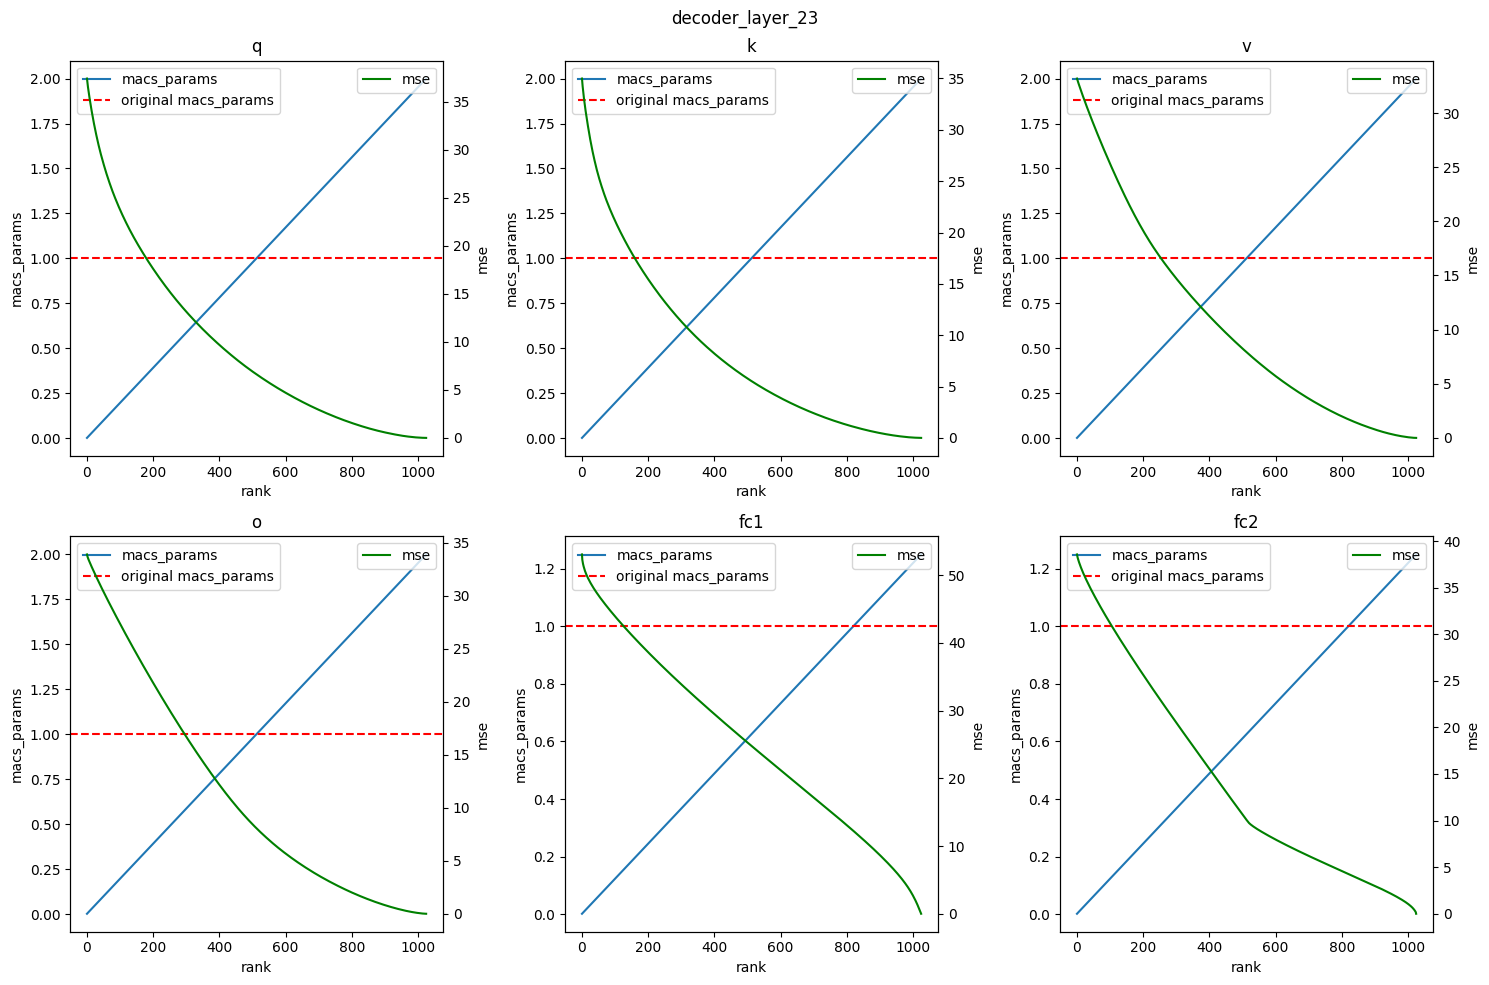

In [2]:
for i in range(len(model.decoder.layers)):
    name = "decoder_layer_{}".format(i)
    # print(name)
    plot_decoder_layer_mse(model.decoder.layers[i], title=name, save_path="figures/"+name+".png")